# 0.0 IMPORTS

In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn import preprocessing as pp
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model  import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from boruta import BorutaPy
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import plotly.graph_objects as go
warnings.filterwarnings('ignore')

## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    #display(HTML('<style>.container {width:100% !important; }</style>'))
    #pd.options.display.max_columns = None
    #pd.options.display.max_rows    = None
    #pd.set_option('display.expand_frame_repr', False)
    
    sns.set()

def ml_error(model_name, y, yhat):
    mae  = mean_absolute_error(y, yhat) 
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index = [0])

layout = go.Layout(autosize=False, width=800, height=250,
                   margin=go.layout.Margin(l=10, r=10, b=10, t=10, pad = 6))

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [4]:
# código referente aos dados do site INMET

# df_aux = pd.read_csv('datasets/clima/br.csv')

# df_aux = df_aux[['Data', 'Hora (UTC)', 'Radiacao (KJ/m²)']]
# df_aux['Data'] = pd.to_datetime(df_aux['Data'], dayfirst=True)

# df_aux['Data'] = df_aux[['Data', 'Hora (UTC)']].apply(lambda x:                                             
#                                         x['Data'] + pd.to_timedelta('0 hours') if x['Hora (UTC)'] == 0 else 
#                                         x['Data'] + pd.to_timedelta('1 hours') if x['Hora (UTC)'] == 100 else 
#                                         x['Data'] + pd.to_timedelta('2 hours') if x['Hora (UTC)'] == 200 else
#                                         x['Data'] + pd.to_timedelta('3 hours') if x['Hora (UTC)'] == 300 else
#                                         x['Data'] + pd.to_timedelta('4 hours') if x['Hora (UTC)'] == 400 else
#                                         x['Data'] + pd.to_timedelta('5 hours') if x['Hora (UTC)'] == 500 else
#                                         x['Data'] + pd.to_timedelta('6 hours') if x['Hora (UTC)'] == 600 else
#                                         x['Data'] + pd.to_timedelta('7 hours') if x['Hora (UTC)'] == 700 else
#                                         x['Data'] + pd.to_timedelta('8 hours') if x['Hora (UTC)'] == 800 else
#                                         x['Data'] + pd.to_timedelta('9 hours') if x['Hora (UTC)'] == 900 else
#                                         x['Data'] + pd.to_timedelta('10 hours') if x['Hora (UTC)'] == 1000 else
#                                         x['Data'] + pd.to_timedelta('11 hours') if x['Hora (UTC)'] == 1100 else
#                                         x['Data'] + pd.to_timedelta('12 hours') if x['Hora (UTC)'] == 1200 else
#                                         x['Data'] + pd.to_timedelta('13 hours') if x['Hora (UTC)'] == 1300 else
#                                         x['Data'] + pd.to_timedelta('14 hours') if x['Hora (UTC)'] == 1400 else
#                                         x['Data'] + pd.to_timedelta('15 hours') if x['Hora (UTC)'] == 1500 else
#                                         x['Data'] + pd.to_timedelta('16 hours') if x['Hora (UTC)'] == 1600 else
#                                         x['Data'] + pd.to_timedelta('17 hours') if x['Hora (UTC)'] == 1700 else
#                                         x['Data'] + pd.to_timedelta('18 hours') if x['Hora (UTC)'] == 1800 else
#                                         x['Data'] + pd.to_timedelta('19 hours') if x['Hora (UTC)'] == 1900 else
#                                         x['Data'] + pd.to_timedelta('20 hours') if x['Hora (UTC)'] == 2000 else
#                                         x['Data'] + pd.to_timedelta('21 hours') if x['Hora (UTC)'] == 2100 else
#                                         x['Data'] + pd.to_timedelta('22 hours') if x['Hora (UTC)'] == 2200 else
#                                         x['Data'] + pd.to_timedelta('23 hours') if x['Hora (UTC)'] == 2300 else
#                                         None, axis = 1)

# df_aux['Data'] = df_aux['Data'].apply(lambda x:  x - pd.to_timedelta('3 hours'))
# df_aux['Radiacao (KJ/m²)'] = (df_aux['Radiacao (KJ/m²)'].str.replace(',', '.')
#                                                        .astype(float))
# df_aux = df_aux[['Data', 'Radiacao (KJ/m²)']]
# df_aux['Date'] = pd.to_datetime(df_aux['Data'].dt.date)
# df_aux.fillna(0, inplace=True)
# dfWeather = df_aux
#dfWeather.head(20)

T2M (MERRA-2 Temperature at 2 Meters (C)) : Faixa de Temperatura a 2 metros
CLRSKY_SFC_SW_DWN (CERES SYN1deg Clear Sky Surface Shortwave Downward Irradiance (Wh/m^2)): Irradiação de onda curta céu limpo
ALLSKY_SFC_SW_DWN (CERES SYN1deg All Sky Surface Shortwave Downward Irradiance (Wh/m^2)): Irradiação de onda curta em todas condições atmosféricas 
ALLSKY_SFC_UVA (CERES SYN1deg All Sky Surface UVA Irradiance (W/m^2)): Irradiação UVA
ALLSKY_SFC_UVB (CERES SYN1deg All Sky Surface UVB Irradiance (W/m^2) ): Irradiação UVB
T2MDEW (MERRA-2 Dew/Frost Point at 2 Meters (C)): Temperatura de formação de orvalho/ geada a 2 metros
QV2M (MERRA-2 Specific Humidity at 2 Meters (g/kg)): Humidade específica a 2 metros (massa de água por massa de ar)
RH2M (MERRA-2 Relative Humidity at 2 Meters (%)): humidade relativa do ar a 2 metros
PRECTOTCORR (MERRA-2 Precipitation Corrected (mm/hour)): precipitação corrigida
PS (MERRA-2 Surface Pressure (kPa)): Pressão atmosférica
WS10M (MERRA-2 Wind Speed at 10 Meters (m/s)): Velocidade do vento a 10 metros
WD10M (MERRA-2 Wind Direction at 10 Meters (Degrees)): Direção do vento a 10 metros


In [5]:
df_aux = pd.read_csv('datasets/clima/ds_weather_nasa.csv')

df_aux.rename(columns={'MO':'MONTH',
                      'DY': 'DAY',
                      'HR': 'HOUR',
                      'CLRSKY_SFC_SW_DWN': 'CLRSKY_SW[Wh/m^2]',
                      'ALLSKY_SFC_SW_DWN': 'ALLSKY_SW[Wh/m^2]',
                      'ALLSKY_SFC_UVA': 'UVA[W/m^2]',
                      'ALLSKY_SFC_UVB': 'UVB[W/m^2]',
                      'T2M': 'T2M[C]',
                      'T2MDEW': 'T2MDEW[C]',
                      'QV2M': 'QV2M[g/kg]',
                      'RH2M': 'RH2M[%]',
                      'PRECTOTCORR':'PREC[mm/hour]',
                      'PS': 'PS[kPa]',
                      'WS10M': 'WS10M[m/s]',
                      'WD10M': 'WD10M[deg]'
                      },
                      inplace=True)
df_aux['TIME'] = pd.to_datetime(df_aux[['YEAR', 'MONTH', 'DAY', 'HOUR']], format='%Y-%m-%d %H:%M:%S')
df_aux.drop(columns=['YEAR', 'MONTH', 'DAY', 'HOUR'], inplace=True)
df_aux['Date'] = pd.to_datetime(df_aux['TIME'].dt.date)
dfWeather = df_aux
dfWeather.head()

T2M[C]  CLRSKY_SW[Wh/m^2]  ALLSKY_SW[Wh/m^2]  UVA[W/m^2]  UVB[W/m^2]  \
0   17.72                0.0                0.0         0.0         0.0   
1   17.54                0.0                0.0         0.0         0.0   
2   17.37                0.0                0.0         0.0         0.0   
3   17.19                0.0                0.0         0.0         0.0   
4   17.03                0.0                0.0         0.0         0.0   

   T2MDEW[C]  QV2M[g/kg]  RH2M[%]  PREC[mm/hour]  PS[kPa]  WS10M[m/s]  \
0      14.52       11.11    81.44           0.01    92.87        6.14   
1      14.70       11.29    83.31           0.00    92.82        5.20   
2      14.86       11.41    85.00           0.00    92.77        4.49   
3      14.93       11.47    86.44           0.00    92.71        4.12   
4      14.93       11.47    87.31           0.01    92.67        3.91   

   WD10M[deg]                TIME       Date  
0      109.54 2021-09-30 21:00:00 2021-09-30  
1      104.35 2021-09-30 22:00:00 2021-09-30  
2      104.11 2021-09-30 23:00:00 2021-09-30  
3      105.27 2021-10-01 00:00:00 2021-10-01  
4      106.84 2021-10-01 01:00:00 2021-10-01

In [6]:
def clean_data(df):
        df.drop(['Number'], axis=1, inplace=True)
        df.head()

        cols = ['Time', 'DC Power PvPV1(W)', 'DC Power PvPV2(W)', 'DC Power PvPV3(W)', 'DC Power PvPV4(W)', 'Total Inverter Power(W)',
                'Today Yield(kWh)', 'Total Yield(kWh)', 'IGBT  Temperature(℃)']

        df = df[cols]
        df['DC Total Power'] = df['DC Power PvPV1(W)'] + df['DC Power PvPV2(W)'] + df['DC Power PvPV3(W)']
        df.drop(['DC Power PvPV1(W)', 'DC Power PvPV2(W)', 'DC Power PvPV3(W)', 'DC Power PvPV4(W)'], axis=1, inplace=True)	
        df['Time'] = df['Time'].str.replace(' (UTC-4:00)', '')
        df['Time'] = pd.to_datetime(df['Time'], dayfirst=True)
        df['Date'] = pd.to_datetime(df['Time'].dt.date)

        return df

In [7]:
df_aux = pd.read_excel('datasets/41/41.xlsx')
dfPower41 = clean_data(df_aux)
dfPower41['Inverter'] = '054B7020C020041'

In [8]:
df_aux = pd.read_excel('datasets/42/42.xlsx')
dfPower42 = clean_data(df_aux)
dfPower42['Inverter'] = '054B7020C020042'

In [9]:
df_aux = pd.read_excel('datasets/44/44.xlsx')
dfPower44 = clean_data(df_aux)
dfPower44['Inverter'] = '054B7020C020044'

In [10]:
dfPower44.head()

Time  Total Inverter Power(W)  Today Yield(kWh)  \
0 2021-10-01 04:47:39                     20.0               0.0   
1 2021-10-01 04:52:39                     20.0               0.0   
2 2021-10-01 04:57:39                     20.0               0.0   
3 2021-10-01 05:02:42                     20.0               0.0   
4 2021-10-01 05:07:47                     20.0               0.0   

   Total Yield(kWh)  IGBT  Temperature(℃)  DC Total Power       Date  \
0             359.0                  25.7              30 2021-10-01   
1             359.0                  25.9              87 2021-10-01   
2             359.0                  26.5              90 2021-10-01   
3             359.0                  27.1              90 2021-10-01   
4             359.0                  27.7              93 2021-10-01   

          Inverter  
0  054B7020C020044  
1  054B7020C020044  
2  054B7020C020044  
3  054B7020C020044  
4  054B7020C020044

In [11]:
dfPower = pd.concat([dfPower41, dfPower42, dfPower44], ignore_index=True)
dfPower = dfPower.sort_values(by=['Time'])
dfPower.reset_index(inplace=True)
dfPower.drop(columns=['index'], inplace=True, axis=1)

In [12]:
df = pd.DataFrame()
for i in range(len(dfPower)):
    for j in range(len(dfWeather)):
        if(((dfPower['Time'].iloc[i].hour == dfWeather['TIME'].iloc[j].hour) &
            (dfPower['Date'].iloc[i] == dfWeather['Date'].iloc[j]))==True):
                df[i] = pd.concat([dfPower.iloc[i], dfWeather.iloc[j]])
df = df.T   
df.drop(['Date', 'Date', 'TIME'], axis=1, inplace=True) 

df.rename(columns={'Time': 'TIME',
                    'Total Inverter Power(W)': 'ACPOWER[W]',
                    'Today Yield(kWh)': 'TODAYY[kWh]',
                    'Total Yield(kWh)': 'TOTALY[kWh]',
                    'IGBT  Temperature(℃)': 'IGBT[C]',
                    'DC Total Power': 'DCPOWER[W]',
                    'Inverter': 'INVERTER'},
                    inplace=True)
df.head()

TIME ACPOWER[W] TODAYY[kWh] TOTALY[kWh] IGBT[C] DCPOWER[W]  \
0  2021-10-01 04:47:39       20.0         0.0       359.0    25.7         30   
1  2021-10-01 04:47:48       20.0         0.0       328.0    26.8         37   
2  2021-10-01 04:48:02       20.0         0.0       359.0    26.3         36   
3  2021-10-01 04:52:39       20.0         0.0       359.0    25.9         87   
4  2021-10-01 04:52:50       20.0         0.0       328.0    27.2         78   

          INVERTER T2M[C] CLRSKY_SW[Wh/m^2] ALLSKY_SW[Wh/m^2] UVA[W/m^2]  \
0  054B7020C020044  17.32               0.0               0.0        0.0   
1  054B7020C020041  17.32               0.0               0.0        0.0   
2  054B7020C020042  17.32               0.0               0.0        0.0   
3  054B7020C020044  17.32               0.0               0.0        0.0   
4  054B7020C020041  17.32               0.0               0.0        0.0   

  UVB[W/m^2] T2MDEW[C] QV2M[g/kg] RH2M[%] PREC[mm/hour] PS[kPa] WS10M[m/s]  \
0        0.0     14.84      11.41   85.19           0.0   92.52       3.16   
1        0.0     14.84      11.41   85.19           0.0   92.52       3.16   
2        0.0     14.84      11.41   85.19           0.0   92.52       3.16   
3        0.0     14.84      11.41   85.19           0.0   92.52       3.16   
4        0.0     14.84      11.41   85.19           0.0   92.52       3.16   

  WD10M[deg]  
0       46.5  
1       46.5  
2       46.5  
3       46.5  
4       46.5

In [13]:
#dfAcPowerT = dfPower44[['Time','Total Inverter Power(W)']]
#dfAcPowerT['Total Inverter Power(W)'] = dfAcPowerT['Total Inverter Power(W)'] + dfPower42['Total Inverter Power(W)'] + dfPower41['Total Inverter Power(W)']

# 1.0 DATA DESCRIPTION

In [14]:
df1 = df.copy()

## 1.2 Data dimension

In [15]:
print('rows:{}'.format(df1.shape[0]))
print('columns:{}'.format(df1.shape[1]))

rows:3213
columns:19


## 1.3 Data Types

In [16]:
df1.dtypes

TIME                 object
ACPOWER[W]           object
TODAYY[kWh]          object
TOTALY[kWh]          object
IGBT[C]              object
DCPOWER[W]           object
INVERTER             object
T2M[C]               object
CLRSKY_SW[Wh/m^2]    object
ALLSKY_SW[Wh/m^2]    object
UVA[W/m^2]           object
UVB[W/m^2]           object
T2MDEW[C]            object
QV2M[g/kg]           object
RH2M[%]              object
PREC[mm/hour]        object
PS[kPa]              object
WS10M[m/s]           object
WD10M[deg]           object
dtype: object

## 1.4 Check NA

In [17]:
df1.isna().sum()

TIME                 0
ACPOWER[W]           0
TODAYY[kWh]          0
TOTALY[kWh]          0
IGBT[C]              0
DCPOWER[W]           0
INVERTER             0
T2M[C]               0
CLRSKY_SW[Wh/m^2]    0
ALLSKY_SW[Wh/m^2]    0
UVA[W/m^2]           0
UVB[W/m^2]           0
T2MDEW[C]            0
QV2M[g/kg]           0
RH2M[%]              0
PREC[mm/hour]        0
PS[kPa]              0
WS10M[m/s]           0
WD10M[deg]           0
dtype: int64

## 1.5 Fillout NA/ Drop duplicates

In [18]:
df1.dropna(inplace=True)

In [19]:
df1 = df1.drop_duplicates()

In [20]:
print('rows:{}'.format(df1.shape[0]))

rows:3213


In [21]:
df1.head()

TIME ACPOWER[W] TODAYY[kWh] TOTALY[kWh] IGBT[C] DCPOWER[W]  \
0  2021-10-01 04:47:39       20.0         0.0       359.0    25.7         30   
1  2021-10-01 04:47:48       20.0         0.0       328.0    26.8         37   
2  2021-10-01 04:48:02       20.0         0.0       359.0    26.3         36   
3  2021-10-01 04:52:39       20.0         0.0       359.0    25.9         87   
4  2021-10-01 04:52:50       20.0         0.0       328.0    27.2         78   

          INVERTER T2M[C] CLRSKY_SW[Wh/m^2] ALLSKY_SW[Wh/m^2] UVA[W/m^2]  \
0  054B7020C020044  17.32               0.0               0.0        0.0   
1  054B7020C020041  17.32               0.0               0.0        0.0   
2  054B7020C020042  17.32               0.0               0.0        0.0   
3  054B7020C020044  17.32               0.0               0.0        0.0   
4  054B7020C020041  17.32               0.0               0.0        0.0   

  UVB[W/m^2] T2MDEW[C] QV2M[g/kg] RH2M[%] PREC[mm/hour] PS[kPa] WS10M[m/s]  \
0        0.0     14.84      11.41   85.19           0.0   92.52       3.16   
1        0.0     14.84      11.41   85.19           0.0   92.52       3.16   
2        0.0     14.84      11.41   85.19           0.0   92.52       3.16   
3        0.0     14.84      11.41   85.19           0.0   92.52       3.16   
4        0.0     14.84      11.41   85.19           0.0   92.52       3.16   

  WD10M[deg]  
0       46.5  
1       46.5  
2       46.5  
3       46.5  
4       46.5

## 1.6 Change Types

In [22]:
df1.columns

Index(['TIME', 'ACPOWER[W]', 'TODAYY[kWh]', 'TOTALY[kWh]', 'IGBT[C]',
       'DCPOWER[W]', 'INVERTER', 'T2M[C]', 'CLRSKY_SW[Wh/m^2]',
       'ALLSKY_SW[Wh/m^2]', 'UVA[W/m^2]', 'UVB[W/m^2]', 'T2MDEW[C]',
       'QV2M[g/kg]', 'RH2M[%]', 'PREC[mm/hour]', 'PS[kPa]', 'WS10M[m/s]',
       'WD10M[deg]'],
      dtype='object')

In [23]:
df1['TIME'] = pd.to_datetime(df1['TIME'], dayfirst=True)
df1['ACPOWER[W]'] = df1['ACPOWER[W]'].astype(float)
df1['TODAYY[kWh]'] = df1['TODAYY[kWh]'].astype(float)
df1['TOTALY[kWh]'] = df1['TOTALY[kWh]'].astype(float)
df1['IGBT[C]'] = df1['IGBT[C]'].astype(float)
df1['DCPOWER[W]'] = df1['DCPOWER[W]'].astype(float)
df1['T2M[C]'] = df1['T2M[C]'].astype(float)
df1['CLRSKY_SW[Wh/m^2]'] = df1['CLRSKY_SW[Wh/m^2]'].astype(float)
df1['ALLSKY_SW[Wh/m^2]'] = df1['ALLSKY_SW[Wh/m^2]'].astype(float)
df1['UVA[W/m^2]'] = df1['UVA[W/m^2]'].astype(float)
df1['UVB[W/m^2]'] = df1['UVB[W/m^2]'].astype(float)
df1['T2MDEW[C]'] = df1['T2MDEW[C]'].astype(float)
df1['QV2M[g/kg]'] = df1['QV2M[g/kg]'].astype(float)
df1['RH2M[%]'] = df1['RH2M[%]'].astype(float)
df1['PREC[mm/hour]'] = df1['PREC[mm/hour]'].astype(float)
df1['PS[kPa]'] = df1['PS[kPa]'].astype(float)
df1['WS10M[m/s]'] = df1['WS10M[m/s]'].astype(float)
df1['WD10M[deg]'] = df1['WD10M[deg]'].astype(float)
df1.dtypes

TIME                 datetime64[ns]
ACPOWER[W]                  float64
TODAYY[kWh]                 float64
TOTALY[kWh]                 float64
IGBT[C]                     float64
DCPOWER[W]                  float64
INVERTER                     object
T2M[C]                      float64
CLRSKY_SW[Wh/m^2]           float64
ALLSKY_SW[Wh/m^2]           float64
UVA[W/m^2]                  float64
UVB[W/m^2]                  float64
T2MDEW[C]                   float64
QV2M[g/kg]                  float64
RH2M[%]                     float64
PREC[mm/hour]               float64
PS[kPa]                     float64
WS10M[m/s]                  float64
WD10M[deg]                  float64
dtype: object

## 1.7 Statistical Description

### 1.7.1 Numerical Attributes

In [24]:
def Statistics(df):
    num_attributes = df.select_dtypes(include = ['int64', 'float64'])
    
    # Central Tendency - mean, median
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T # transform to dataframe to facilitate visualization
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

    # Dispersion - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(num_attributes.apply(np.std)).T
    d2 = pd.DataFrame(num_attributes.apply(min)).T
    d3 = pd.DataFrame(num_attributes.apply(max)).T
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T # skewness
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

    # concatenate
    m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    
    return m

In [25]:
Statistics(df1)

attributes     min      max    range         mean   median  \
0          ACPOWER[W]    0.00  9020.00  9020.00  2815.203859  2230.00   
1         TODAYY[kWh]    0.00    54.80    54.80    18.413010    16.30   
2         TOTALY[kWh]  328.00   617.00   289.00   473.648304   462.00   
3             IGBT[C]   24.10    70.00    45.90    44.496265    42.30   
4          DCPOWER[W]    0.00  9333.00  9333.00  2901.901338  2301.00   
5              T2M[C]   15.06    36.24    21.18    26.798559    28.30   
6   CLRSKY_SW[Wh/m^2]    0.00   974.23   974.23   533.320566   557.92   
7   ALLSKY_SW[Wh/m^2]    0.00   953.72   953.72   348.364357   279.77   
8          UVA[W/m^2]    0.00    58.57    58.57    21.305711    18.62   
9          UVB[W/m^2]    0.00     1.89     1.89     0.579558     0.45   
10          T2MDEW[C]   11.90    20.60     8.70    15.332020    15.40   
11         QV2M[g/kg]    9.40    16.54     7.14    11.803666    11.78   
12            RH2M[%]   23.12    94.12    71.00    53.472810    46.19   
13      PREC[mm/hour]    0.00     2.53     2.53     0.203856     0.02   
14            PS[kPa]   92.31    93.24     0.93    92.736138    92.71   
15         WS10M[m/s]    0.70     8.89     8.19     4.753340     4.57   
16         WD10M[deg]    5.77   357.55   351.78   215.285058   265.85   

            std      skew  kurtosis  
0   2370.719298  0.560604 -0.891748  
1     15.164758  0.468424 -0.926536  
2     79.321643  0.172379 -1.107020  
3     11.209065  0.432337 -0.866047  
4   2416.664789  0.565970 -0.879380  
5      5.587997 -0.369964 -0.993717  
6    329.693481 -0.294831 -1.339325  
7    271.012000  0.547179 -0.748081  
8     16.444395  0.498501 -0.781821  
9      0.546209  0.734495 -0.597566  
10     1.480590 -0.188593  0.313433  
11     1.121856  0.158009  0.550532  
12    20.537580  0.517958 -1.030989  
13     0.539875  3.185538  9.442548  
14     0.217121  0.393753 -0.277774  
15     1.799882  0.301242 -0.450946  
16   105.886536 -0.558654 -1.000993

In [26]:
df1.columns

Index(['TIME', 'ACPOWER[W]', 'TODAYY[kWh]', 'TOTALY[kWh]', 'IGBT[C]',
       'DCPOWER[W]', 'INVERTER', 'T2M[C]', 'CLRSKY_SW[Wh/m^2]',
       'ALLSKY_SW[Wh/m^2]', 'UVA[W/m^2]', 'UVB[W/m^2]', 'T2MDEW[C]',
       'QV2M[g/kg]', 'RH2M[%]', 'PREC[mm/hour]', 'PS[kPa]', 'WS10M[m/s]',
       'WD10M[deg]'],
      dtype='object')

In [27]:
df1[['ACPOWER[W]', 'TODAYY[kWh]', 'TOTALY[kWh]', 'IGBT[C]', 'DCPOWER[W]', 'INVERTER']].describe()

ACPOWER[W]  TODAYY[kWh]  TOTALY[kWh]      IGBT[C]   DCPOWER[W]
count  3213.000000  3213.000000  3213.000000  3213.000000  3213.000000
mean   2815.203859    18.413010   473.648304    44.496265  2901.901338
std    2371.088310    15.167119    79.333989    11.210810  2417.040953
min       0.000000     0.000000   328.000000    24.100000     0.000000
25%     680.000000     4.200000   406.000000    35.100000   720.000000
50%    2230.000000    16.300000   462.000000    42.300000  2301.000000
75%    4540.000000    32.000000   543.000000    52.900000  4643.000000
max    9020.000000    54.800000   617.000000    70.000000  9333.000000

In [28]:
df1[['T2M[C]', 'CLRSKY_SW[Wh/m^2]', 'ALLSKY_SW[Wh/m^2]', 'UVA[W/m^2]', 'UVB[W/m^2]', 'T2MDEW[C]', 'QV2M[g/kg]', 'RH2M[%]', 'PREC[mm/hour]', 'PS[kPa]', 'WS10M[m/s]', 'WD10M[deg]']].describe()

T2M[C]  CLRSKY_SW[Wh/m^2]  ALLSKY_SW[Wh/m^2]   UVA[W/m^2]  \
count  3213.000000        3213.000000        3213.000000  3213.000000   
mean     26.798559         533.320566         348.364357    21.305711   
std       5.588867         329.744799         271.054184    16.446955   
min      15.060000           0.000000           0.000000     0.000000   
25%      21.730000         269.950000         116.850000     7.280000   
50%      28.300000         557.920000         279.770000    18.620000   
75%      31.180000         851.520000         554.670000    33.550000   
max      36.240000         974.230000         953.720000    58.570000   

        UVB[W/m^2]    T2MDEW[C]   QV2M[g/kg]      RH2M[%]  PREC[mm/hour]  \
count  3213.000000  3213.000000  3213.000000  3213.000000    3213.000000   
mean      0.579558    15.332020    11.803666    53.472810       0.203856   
std       0.546294     1.480821     1.122030    20.540777       0.539959   
min       0.000000    11.900000     9.400000    23.120000       0.000000   
25%       0.090000    14.520000    11.170000    38.620000       0.000000   
50%       0.450000    15.400000    11.780000    46.190000       0.020000   
75%       0.990000    16.270000    12.510000    72.440000       0.050000   
max       1.890000    20.600000    16.540000    94.120000       2.530000   

           PS[kPa]   WS10M[m/s]   WD10M[deg]  
count  3213.000000  3213.000000  3213.000000  
mean     92.736138     4.753340   215.285058  
std       0.217154     1.800162   105.903017  
min      92.310000     0.700000     5.770000  
25%      92.590000     3.350000   144.920000  
50%      92.710000     4.570000   265.850000  
75%      92.860000     6.020000   301.600000  
max      93.240000     8.890000   357.550000

### 1.7.2 Categorical Attributes

In [29]:
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]']) 
cat_attributes

INVERTER
0     054B7020C020044
1     054B7020C020041
2     054B7020C020042
3     054B7020C020044
4     054B7020C020041
...               ...
3208  054B7020C020042
3209  054B7020C020044
3210  054B7020C020041
3211  054B7020C020042
3212  054B7020C020044

[3213 rows x 1 columns]

# 2.0 FEATURE ENGINEERING

In [30]:
df2 = df1.copy()

In [31]:
df2.head()

TIME  ACPOWER[W]  TODAYY[kWh]  TOTALY[kWh]  IGBT[C]  \
0 2021-10-01 04:47:39        20.0          0.0        359.0     25.7   
1 2021-10-01 04:47:48        20.0          0.0        328.0     26.8   
2 2021-10-01 04:48:02        20.0          0.0        359.0     26.3   
3 2021-10-01 04:52:39        20.0          0.0        359.0     25.9   
4 2021-10-01 04:52:50        20.0          0.0        328.0     27.2   

   DCPOWER[W]         INVERTER  T2M[C]  CLRSKY_SW[Wh/m^2]  ALLSKY_SW[Wh/m^2]  \
0        30.0  054B7020C020044   17.32                0.0                0.0   
1        37.0  054B7020C020041   17.32                0.0                0.0   
2        36.0  054B7020C020042   17.32                0.0                0.0   
3        87.0  054B7020C020044   17.32                0.0                0.0   
4        78.0  054B7020C020041   17.32                0.0                0.0   

   UVA[W/m^2]  UVB[W/m^2]  T2MDEW[C]  QV2M[g/kg]  RH2M[%]  PREC[mm/hour]  \
0         0.0         0.0      14.84       11.41    85.19            0.0   
1         0.0         0.0      14.84       11.41    85.19            0.0   
2         0.0         0.0      14.84       11.41    85.19            0.0   
3         0.0         0.0      14.84       11.41    85.19            0.0   
4         0.0         0.0      14.84       11.41    85.19            0.0   

   PS[kPa]  WS10M[m/s]  WD10M[deg]  
0    92.52        3.16        46.5  
1    92.52        3.16        46.5  
2    92.52        3.16        46.5  
3    92.52        3.16        46.5  
4    92.52        3.16        46.5

In [32]:
df2['DATE'] = pd.to_datetime(df2['TIME'].dt.date)
df2['YEAR'] = df2['TIME'].dt.year
df2['MONTH'] = df2['TIME'].dt.month
df2['WEEK_YEAR'] = df2['TIME'].dt.isocalendar()['week']
df2['DAY_WEEK'] = df2['TIME'].dt.dayofweek.apply(lambda x: x + 1)
df2['DAY'] = df2['TIME'].dt.day
df2['HOUR'] = df2['TIME'].dt.hour
df2['MIN'] = df2['TIME'].dt.minute

In [33]:
df2.dtypes

TIME                 datetime64[ns]
ACPOWER[W]                  float64
TODAYY[kWh]                 float64
TOTALY[kWh]                 float64
IGBT[C]                     float64
DCPOWER[W]                  float64
INVERTER                     object
T2M[C]                      float64
CLRSKY_SW[Wh/m^2]           float64
ALLSKY_SW[Wh/m^2]           float64
UVA[W/m^2]                  float64
UVB[W/m^2]                  float64
T2MDEW[C]                   float64
QV2M[g/kg]                  float64
RH2M[%]                     float64
PREC[mm/hour]               float64
PS[kPa]                     float64
WS10M[m/s]                  float64
WD10M[deg]                  float64
DATE                 datetime64[ns]
YEAR                          int32
MONTH                         int32
WEEK_YEAR                    UInt32
DAY_WEEK                      int64
DAY                           int32
HOUR                          int32
MIN                           int32
dtype: object

In [34]:
df2.to_csv('datasets/dfPower.csv')

In [35]:
df2 = pd.read_csv('datasets/dfPower.csv')
df2.drop(['Unnamed: 0'], axis=1, inplace=True);

In [36]:
df2.head()

TIME  ACPOWER[W]  TODAYY[kWh]  TOTALY[kWh]  IGBT[C]  \
0  2021-10-01 04:47:39        20.0          0.0        359.0     25.7   
1  2021-10-01 04:47:48        20.0          0.0        328.0     26.8   
2  2021-10-01 04:48:02        20.0          0.0        359.0     26.3   
3  2021-10-01 04:52:39        20.0          0.0        359.0     25.9   
4  2021-10-01 04:52:50        20.0          0.0        328.0     27.2   

   DCPOWER[W]         INVERTER  T2M[C]  CLRSKY_SW[Wh/m^2]  ALLSKY_SW[Wh/m^2]  \
0        30.0  054B7020C020044   17.32                0.0                0.0   
1        37.0  054B7020C020041   17.32                0.0                0.0   
2        36.0  054B7020C020042   17.32                0.0                0.0   
3        87.0  054B7020C020044   17.32                0.0                0.0   
4        78.0  054B7020C020041   17.32                0.0                0.0   

   ...  WS10M[m/s]  WD10M[deg]        DATE  YEAR  MONTH  WEEK_YEAR  DAY_WEEK  \
0  ...        3.16        46.5  2021-10-01  2021     10         39         5   
1  ...        3.16        46.5  2021-10-01  2021     10         39         5   
2  ...        3.16        46.5  2021-10-01  2021     10         39         5   
3  ...        3.16        46.5  2021-10-01  2021     10         39         5   
4  ...        3.16        46.5  2021-10-01  2021     10         39         5   

   DAY  HOUR MIN  
0    1     4  47  
1    1     4  47  
2    1     4  48  
3    1     4  52  
4    1     4  52  

[5 rows x 27 columns]

In [37]:
df2['TIME'] = pd.to_datetime(df2['TIME'])#, dayfirst=True)
df2['ACPOWER[W]'] = df2['ACPOWER[W]'].astype(float)
df2['TODAYY[kWh]'] = df2['TODAYY[kWh]'].astype(float)
df2['TOTALY[kWh]'] = df2['TOTALY[kWh]'].astype(float)
df2['IGBT[C]'] = df2['IGBT[C]'].astype(float)
df2['DCPOWER[W]'] = df2['DCPOWER[W]'].astype(float)
df2['T2M[C]'] = df2['T2M[C]'].astype(float)
df2['CLRSKY_SW[Wh/m^2]'] = df2['CLRSKY_SW[Wh/m^2]'].astype(float)
df2['ALLSKY_SW[Wh/m^2]'] = df2['ALLSKY_SW[Wh/m^2]'].astype(float)
df2['UVA[W/m^2]'] = df2['UVA[W/m^2]'].astype(float)
df2['UVB[W/m^2]'] = df2['UVB[W/m^2]'].astype(float)
df2['T2MDEW[C]'] = df2['T2MDEW[C]'].astype(float)
df2['QV2M[g/kg]'] = df2['QV2M[g/kg]'].astype(float)
df2['RH2M[%]'] = df2['RH2M[%]'].astype(float)
df2['PREC[mm/hour]'] = df2['PREC[mm/hour]'].astype(float)
df2['PS[kPa]'] = df2['PS[kPa]'].astype(float)
df2['WS10M[m/s]'] = df2['WS10M[m/s]'].astype(float)
df2['DATE'] = pd.to_datetime(df2['TIME'].dt.date, dayfirst=True)
df2['YEAR'] = df2['TIME'].dt.year
df2['MONTH'] = df2['TIME'].dt.month
df2['WEEK_YEAR'] = df2['TIME'].dt.isocalendar()['week']
df2['DAY_WEEK'] = df2['TIME'].dt.dayofweek.apply(lambda x: x + 1)
df2['DAY'] = df2['TIME'].dt.day
df2['HOUR'] = df2['TIME'].dt.hour
df2['MIN'] = df2['TIME'].dt.minute
df2.dtypes

TIME                 datetime64[ns]
ACPOWER[W]                  float64
TODAYY[kWh]                 float64
TOTALY[kWh]                 float64
IGBT[C]                     float64
DCPOWER[W]                  float64
INVERTER                     object
T2M[C]                      float64
CLRSKY_SW[Wh/m^2]           float64
ALLSKY_SW[Wh/m^2]           float64
UVA[W/m^2]                  float64
UVB[W/m^2]                  float64
T2MDEW[C]                   float64
QV2M[g/kg]                  float64
RH2M[%]                     float64
PREC[mm/hour]               float64
PS[kPa]                     float64
WS10M[m/s]                  float64
WD10M[deg]                  float64
DATE                 datetime64[ns]
YEAR                          int32
MONTH                         int32
WEEK_YEAR                    UInt32
DAY_WEEK                      int64
DAY                           int32
HOUR                          int32
MIN                           int32
dtype: object

In [38]:
df2.head()

TIME  ACPOWER[W]  TODAYY[kWh]  TOTALY[kWh]  IGBT[C]  \
0 2021-10-01 04:47:39        20.0          0.0        359.0     25.7   
1 2021-10-01 04:47:48        20.0          0.0        328.0     26.8   
2 2021-10-01 04:48:02        20.0          0.0        359.0     26.3   
3 2021-10-01 04:52:39        20.0          0.0        359.0     25.9   
4 2021-10-01 04:52:50        20.0          0.0        328.0     27.2   

   DCPOWER[W]         INVERTER  T2M[C]  CLRSKY_SW[Wh/m^2]  ALLSKY_SW[Wh/m^2]  \
0        30.0  054B7020C020044   17.32                0.0                0.0   
1        37.0  054B7020C020041   17.32                0.0                0.0   
2        36.0  054B7020C020042   17.32                0.0                0.0   
3        87.0  054B7020C020044   17.32                0.0                0.0   
4        78.0  054B7020C020041   17.32                0.0                0.0   

   ...  WS10M[m/s]  WD10M[deg]       DATE  YEAR  MONTH  WEEK_YEAR  DAY_WEEK  \
0  ...        3.16        46.5 2021-10-01  2021     10         39         5   
1  ...        3.16        46.5 2021-10-01  2021     10         39         5   
2  ...        3.16        46.5 2021-10-01  2021     10         39         5   
3  ...        3.16        46.5 2021-10-01  2021     10         39         5   
4  ...        3.16        46.5 2021-10-01  2021     10         39         5   

   DAY  HOUR MIN  
0    1     4  47  
1    1     4  47  
2    1     4  48  
3    1     4  52  
4    1     4  52  

[5 rows x 27 columns]

# 3.0 FILTERING OF VARIABLES

In [39]:
df3 = df2.copy()

In [40]:
df3.head()

TIME  ACPOWER[W]  TODAYY[kWh]  TOTALY[kWh]  IGBT[C]  \
0 2021-10-01 04:47:39        20.0          0.0        359.0     25.7   
1 2021-10-01 04:47:48        20.0          0.0        328.0     26.8   
2 2021-10-01 04:48:02        20.0          0.0        359.0     26.3   
3 2021-10-01 04:52:39        20.0          0.0        359.0     25.9   
4 2021-10-01 04:52:50        20.0          0.0        328.0     27.2   

   DCPOWER[W]         INVERTER  T2M[C]  CLRSKY_SW[Wh/m^2]  ALLSKY_SW[Wh/m^2]  \
0        30.0  054B7020C020044   17.32                0.0                0.0   
1        37.0  054B7020C020041   17.32                0.0                0.0   
2        36.0  054B7020C020042   17.32                0.0                0.0   
3        87.0  054B7020C020044   17.32                0.0                0.0   
4        78.0  054B7020C020041   17.32                0.0                0.0   

   ...  WS10M[m/s]  WD10M[deg]       DATE  YEAR  MONTH  WEEK_YEAR  DAY_WEEK  \
0  ...        3.16        46.5 2021-10-01  2021     10         39         5   
1  ...        3.16        46.5 2021-10-01  2021     10         39         5   
2  ...        3.16        46.5 2021-10-01  2021     10         39         5   
3  ...        3.16        46.5 2021-10-01  2021     10         39         5   
4  ...        3.16        46.5 2021-10-01  2021     10         39         5   

   DAY  HOUR MIN  
0    1     4  47  
1    1     4  47  
2    1     4  48  
3    1     4  52  
4    1     4  52  

[5 rows x 27 columns]

# 4.0 EXPLORATORY DATA ANALYSIS

In [41]:
df4 = df3.copy()

In [42]:
df4.head()

TIME  ACPOWER[W]  TODAYY[kWh]  TOTALY[kWh]  IGBT[C]  \
0 2021-10-01 04:47:39        20.0          0.0        359.0     25.7   
1 2021-10-01 04:47:48        20.0          0.0        328.0     26.8   
2 2021-10-01 04:48:02        20.0          0.0        359.0     26.3   
3 2021-10-01 04:52:39        20.0          0.0        359.0     25.9   
4 2021-10-01 04:52:50        20.0          0.0        328.0     27.2   

   DCPOWER[W]         INVERTER  T2M[C]  CLRSKY_SW[Wh/m^2]  ALLSKY_SW[Wh/m^2]  \
0        30.0  054B7020C020044   17.32                0.0                0.0   
1        37.0  054B7020C020041   17.32                0.0                0.0   
2        36.0  054B7020C020042   17.32                0.0                0.0   
3        87.0  054B7020C020044   17.32                0.0                0.0   
4        78.0  054B7020C020041   17.32                0.0                0.0   

   ...  WS10M[m/s]  WD10M[deg]       DATE  YEAR  MONTH  WEEK_YEAR  DAY_WEEK  \
0  ...        3.16        46.5 2021-10-01  2021     10         39         5   
1  ...        3.16        46.5 2021-10-01  2021     10         39         5   
2  ...        3.16        46.5 2021-10-01  2021     10         39         5   
3  ...        3.16        46.5 2021-10-01  2021     10         39         5   
4  ...        3.16        46.5 2021-10-01  2021     10         39         5   

   DAY  HOUR MIN  
0    1     4  47  
1    1     4  47  
2    1     4  48  
3    1     4  52  
4    1     4  52  

[5 rows x 27 columns]

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

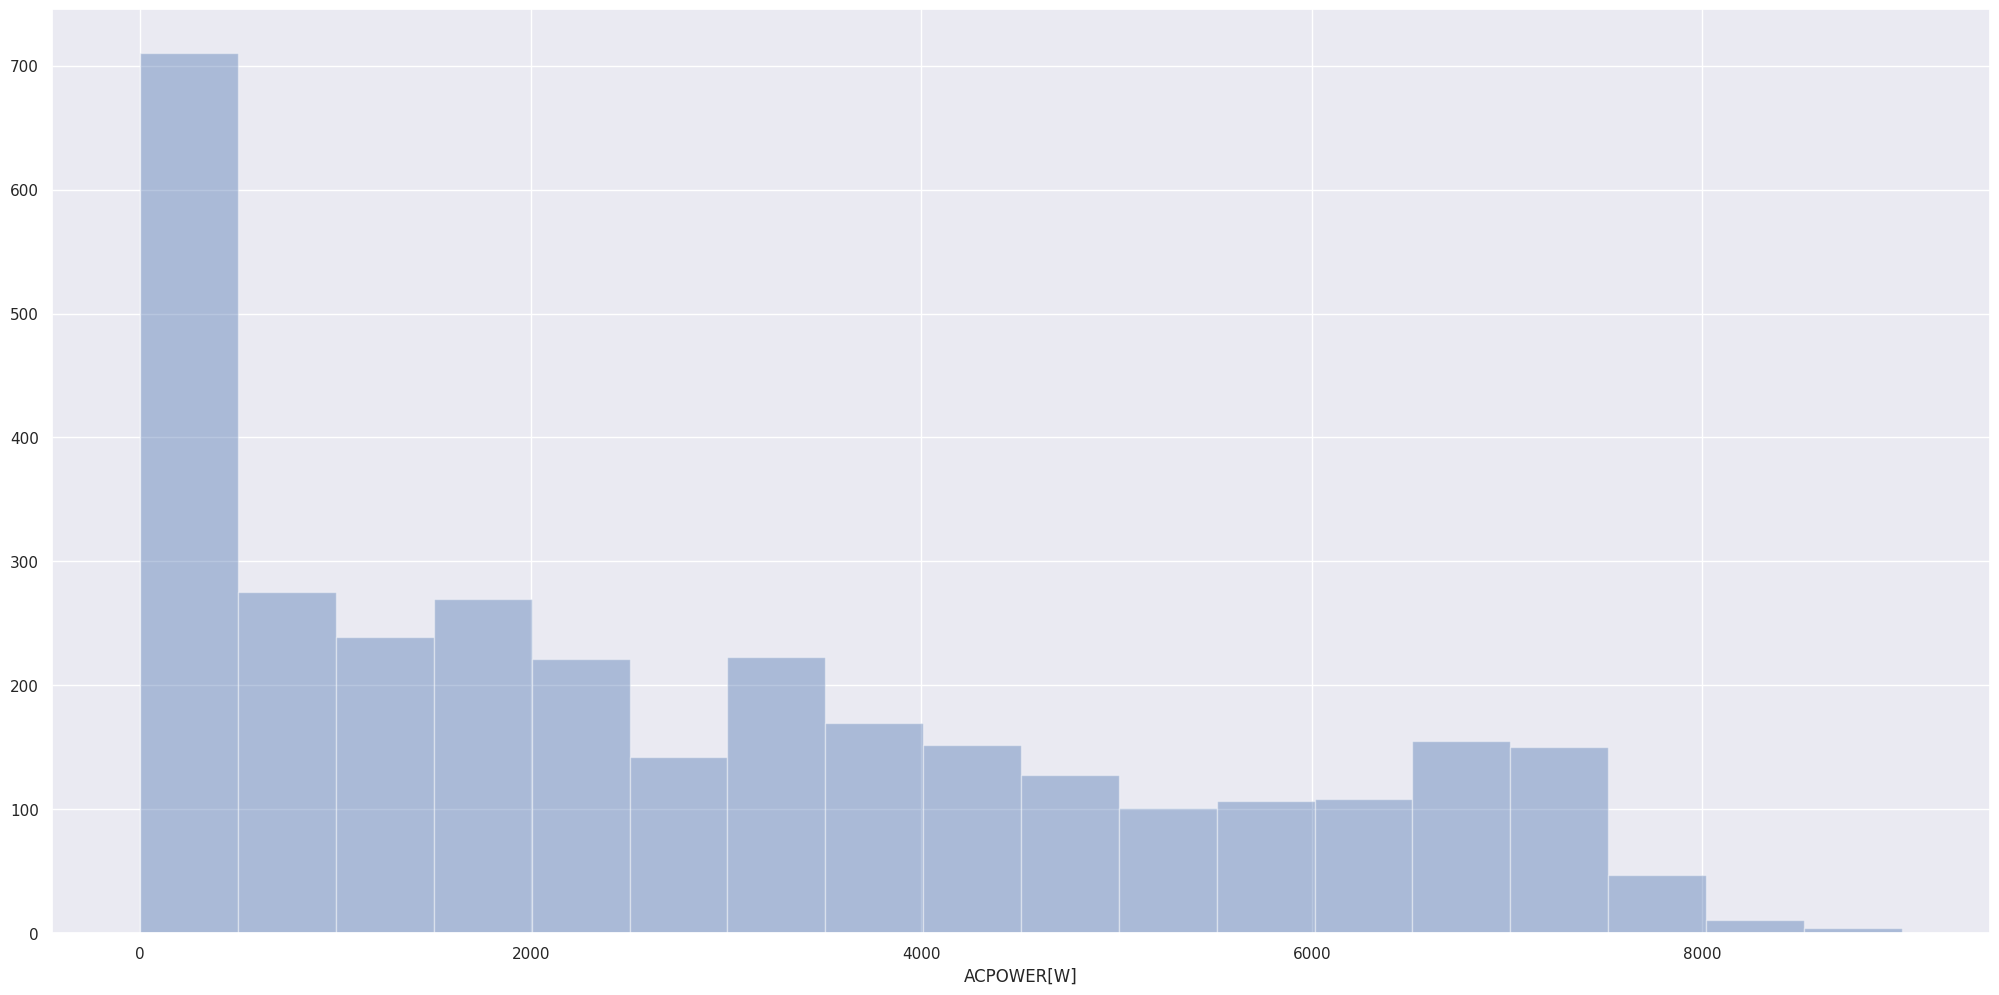

In [43]:
sns.distplot(df4['ACPOWER[W]'], kde=False);

### 4.1.2 Numerical Variable

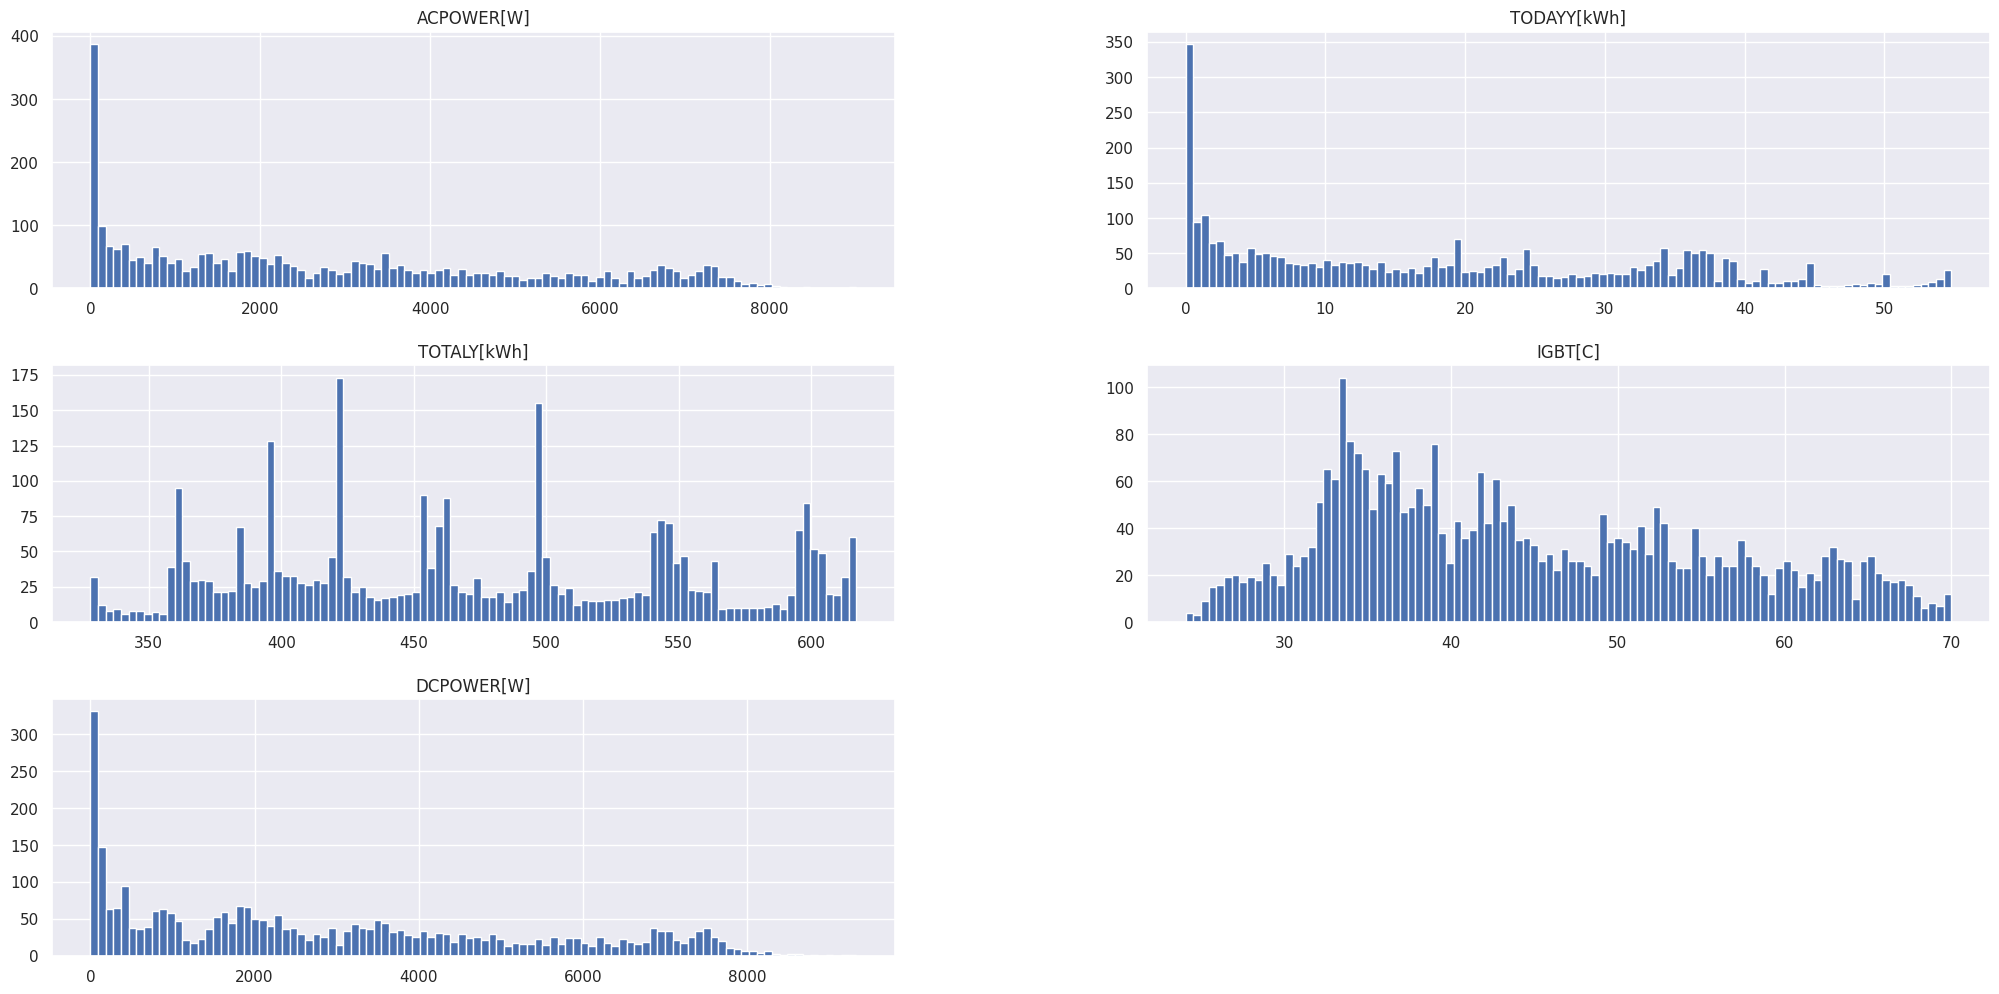

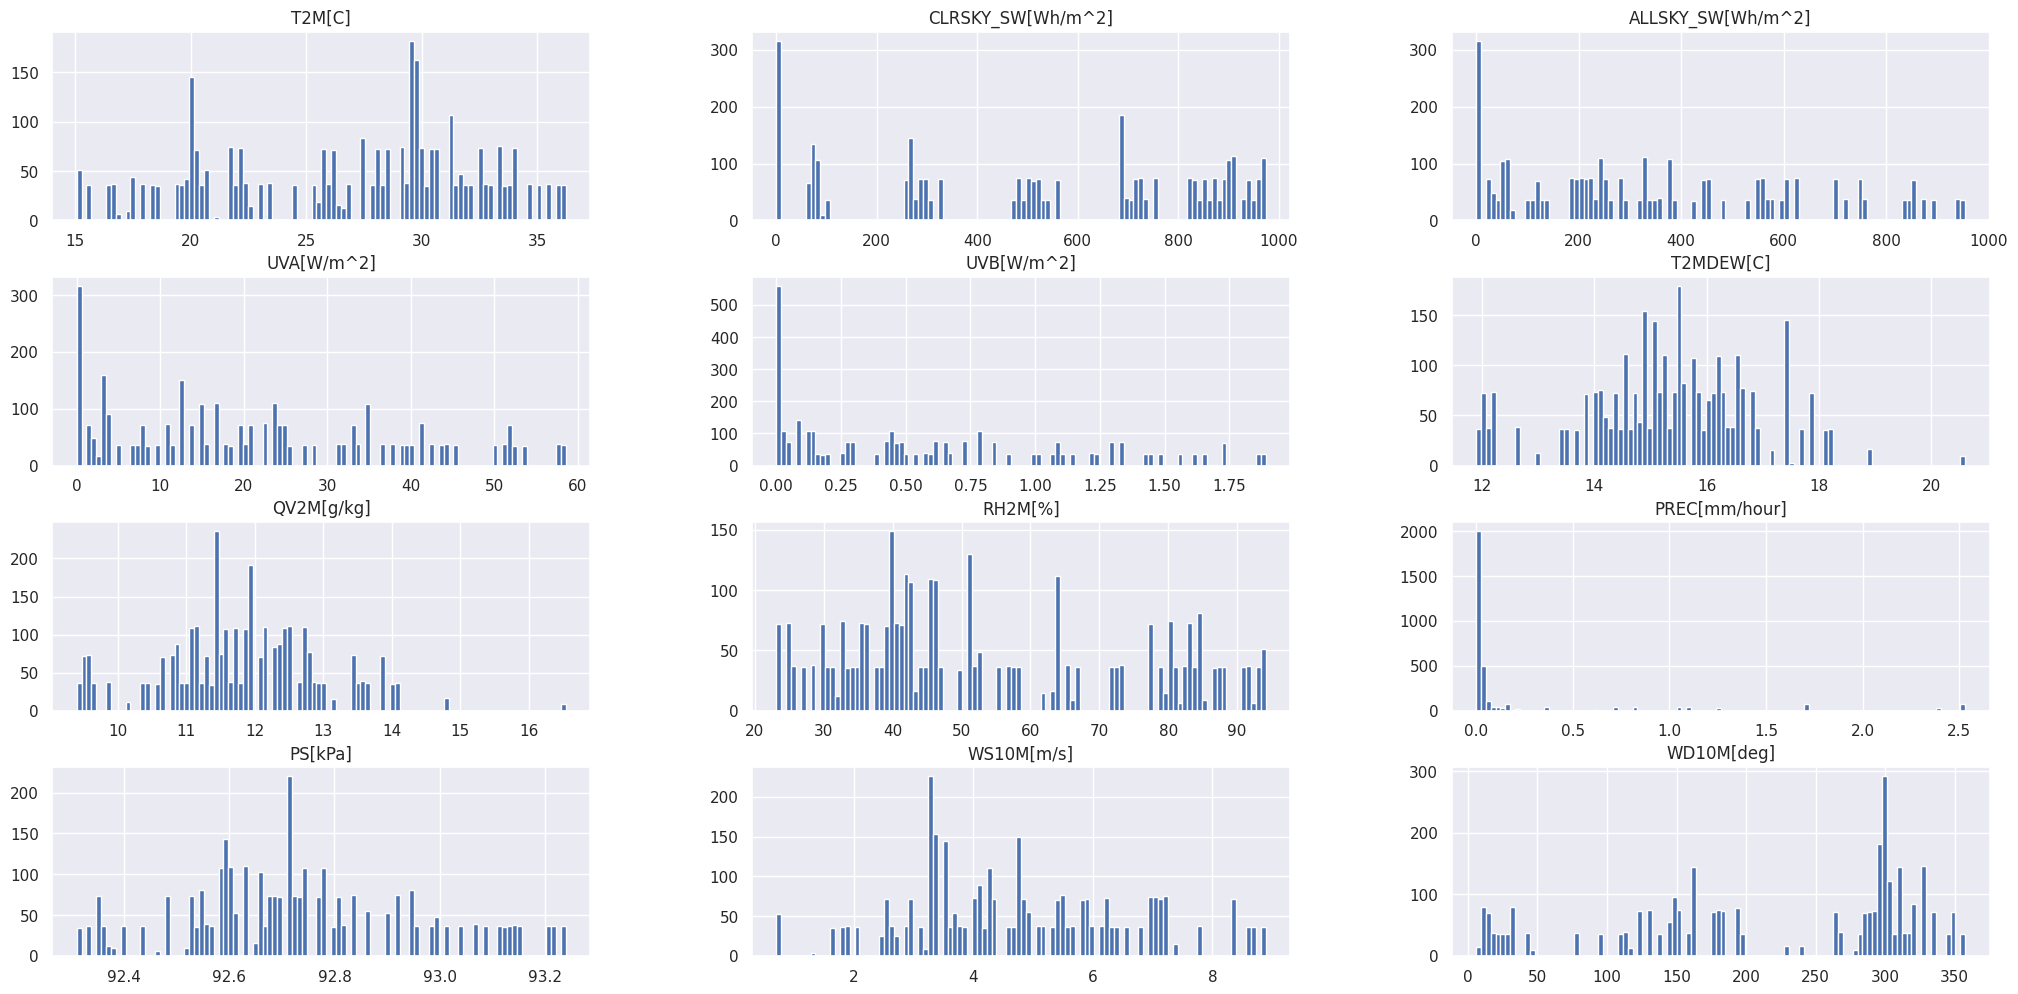

In [44]:
num_attributes = df4.select_dtypes(include = ['int64', 'float64'])
num_attributes[['ACPOWER[W]', 'TODAYY[kWh]', 'TOTALY[kWh]', 'IGBT[C]', 'DCPOWER[W]']].hist(bins=100);
num_attributes[['T2M[C]', 'CLRSKY_SW[Wh/m^2]', 'ALLSKY_SW[Wh/m^2]', 'UVA[W/m^2]', 'UVB[W/m^2]', 'T2MDEW[C]', 'QV2M[g/kg]', 'RH2M[%]', 'PREC[mm/hour]', 'PS[kPa]', 'WS10M[m/s]', 'WD10M[deg]']].hist(bins=100);

### 4.1.3 Geração AC x DC

In [45]:
# Potência AC e DC média gerada em um período de 6 horas
fig = go.Figure(layout = layout)
fig.add_trace(go.Histogram(histfunc="avg", y=df1["DCPOWER[W]"], x=df4["TIME"], name="Potência DC"))
fig.add_trace(go.Histogram(histfunc="avg", y=df1["ACPOWER[W]"], x=df4["TIME"], name="Potência AC"))

fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.5)

fig.update_yaxes(title_text='Potência média (W)')

In [46]:
# Potência AC e DC total gerada em um período de 6 horas
fig = go.Figure(layout = layout)
fig.add_trace(go.Histogram(histfunc="sum", y=df1["DCPOWER[W]"], x=df4["TIME"], name="Potência DC"))
fig.add_trace(go.Histogram(histfunc="sum", y=df1["ACPOWER[W]"], x=df4["TIME"], name="Potência AC"))

fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.5)

fig.update_yaxes(title_text='Potência média (W)')

Perdas média:  96.89994729244799


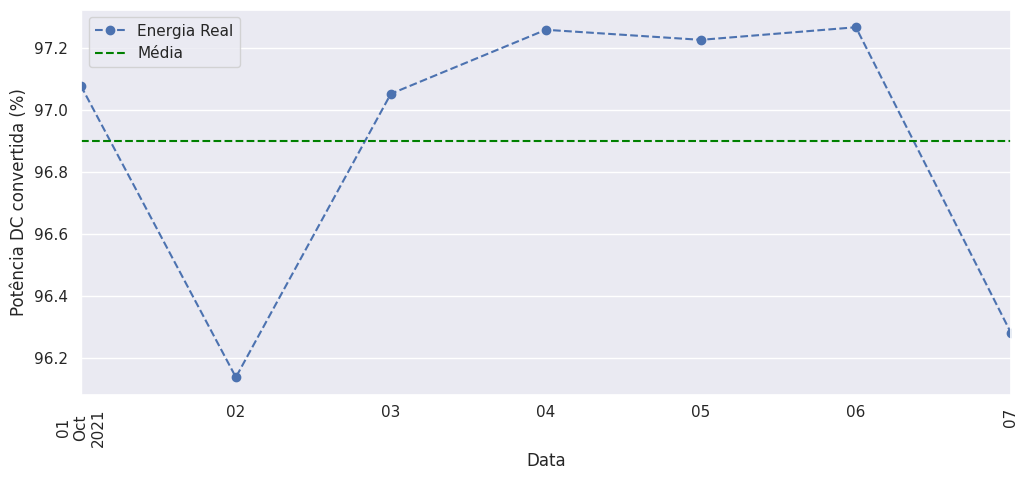

In [47]:
# Perdas na geração de energia
perdas=df4.copy() # Copia conteúdo da tabela de dados da planta
perdas=perdas[['ACPOWER[W]', 'DCPOWER[W]', 'DATE']].groupby('DATE').sum() # Agrupa todos os dados para as 34 datas
perdas['perdas']=perdas['ACPOWER[W]']/perdas['DCPOWER[W]']*100 # Reune os dados de energia real convertida

perdas['perdas'].plot(style='o--',figsize=(12,5),label='Energia Real') # Plota os dados de energia real convertida

print('Perdas média: ', perdas['perdas'].mean())

plt.ylabel('Potência DC convertida (%)',fontsize=12)
plt.xlabel('Data',fontsize=12)
plt.axhline(perdas['perdas'].mean(),linestyle='--',color='green',label='Média') # Plota linha com a média dos dados de energia convertida
plt.xticks(rotation = 90)
plt.legend()
plt.show();

### 4.1.4 Irradiação

In [48]:
# Irradiação média gerada em um período de 6 horas
fig = go.Figure(layout = layout)
fig = px.histogram(df4, labels={"TIME": "Data"}, x="TIME", y="ALLSKY_SW[Wh/m^2]", histfunc='avg')
fig.update_yaxes(title_text='Irradiação média (Wh/m²)')

### 4.1.5 Temperatura

In [49]:
fig = go.Figure(layout = layout)
fig.add_trace(go.Histogram(histfunc="avg", y=df1['IGBT[C]'], x=df4['TIME'], name="IGBT"))
fig.add_trace(go.Histogram(histfunc="avg", y=df1['T2M[C]'], x=df4['TIME'], name="Temp Ambiente"))

fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.5)

fig.update_yaxes(title_text='Temperatura média (ºC)')

### 4.1.6 Geração Horária

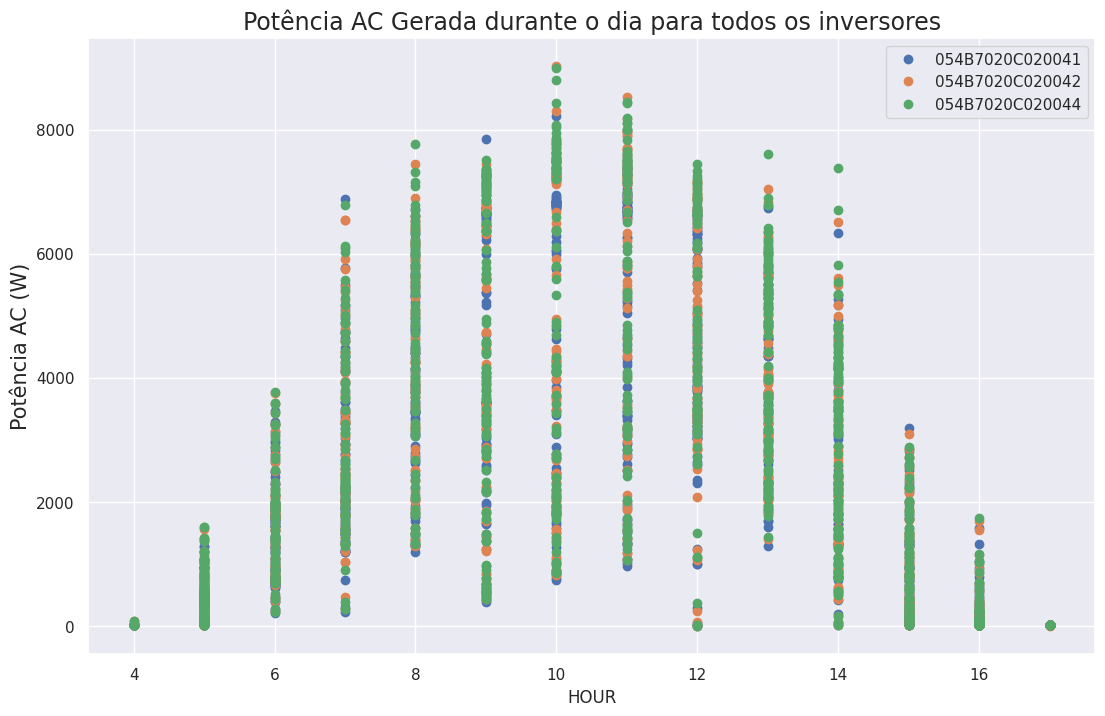

In [50]:
inversores = df4.copy()
inversores.set_index('HOUR').groupby('INVERTER')['ACPOWER[W]'].plot(style='o', legend=True, figsize=(13,8))

plt.title('Potência AC Gerada durante o dia para todos os inversores', size=17)
plt.ylabel('Potência AC (W)', fontsize=15)
plt.legend()
plt.show()

In [51]:
# Removendo intervalo onde a geração de enegia é nula
filtro = (df4['TIME'].dt.hour > 4) & (df4['TIME'].dt.hour < 17)
df4 = df4[filtro]

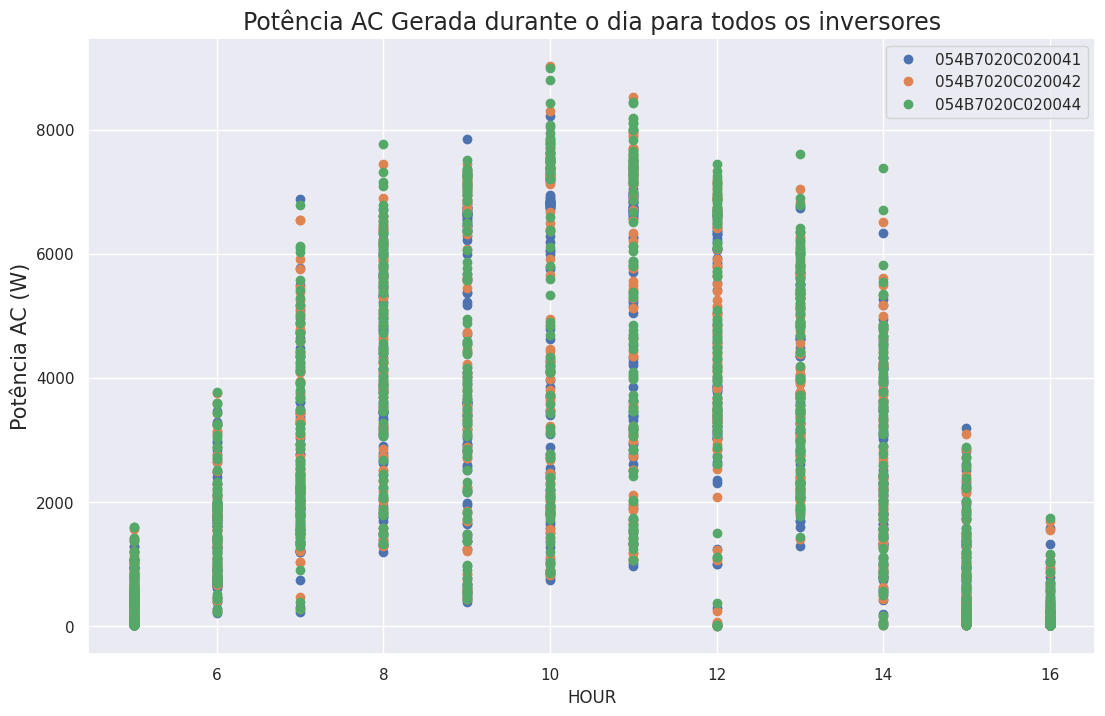

In [52]:
# gráfico sem os dados de geração nula
inversores = df4.copy()
inversores.set_index('HOUR').groupby('INVERTER')['ACPOWER[W]'].plot(style='o', legend=True, figsize=(13,8))

plt.title('Potência AC Gerada durante o dia para todos os inversores', size=17)
plt.ylabel('Potência AC (W)', fontsize=15)
plt.legend()
plt.show()

### 4.1.7 Verificação de valores nulos de geração

In [53]:
# Reunir os valores nulos de energia
dataframe = df4.copy()
filtro = df4['ACPOWER[W]'] == 0

geracaoACNula = dataframe[filtro]

# Histograma com as quantidade de valores nulos 
diasNulos = geracaoACNula['HOUR']

fig = px.histogram(geracaoACNula, labels={"x": "Data"}, x=diasNulos, y="ACPOWER[W]", histfunc='count')
fig.update_yaxes(title_text='Quantidade de valores nulos')

In [54]:
# Histograma com a média de irradiação para quando a geração de energia foi nula
diasNulos = geracaoACNula['HOUR']

fig = go.Figure(layout = layout)
fig = px.histogram(geracaoACNula, labels={'x': "Hora"}, x=diasNulos, y="ALLSKY_SW[Wh/m^2]", histfunc='avg')
fig.update_yaxes(title_text='Irradiação solar média para os valores nulos (Wh/m²)')

### 4.1.8 Geração dos 7 dias para cada inversor

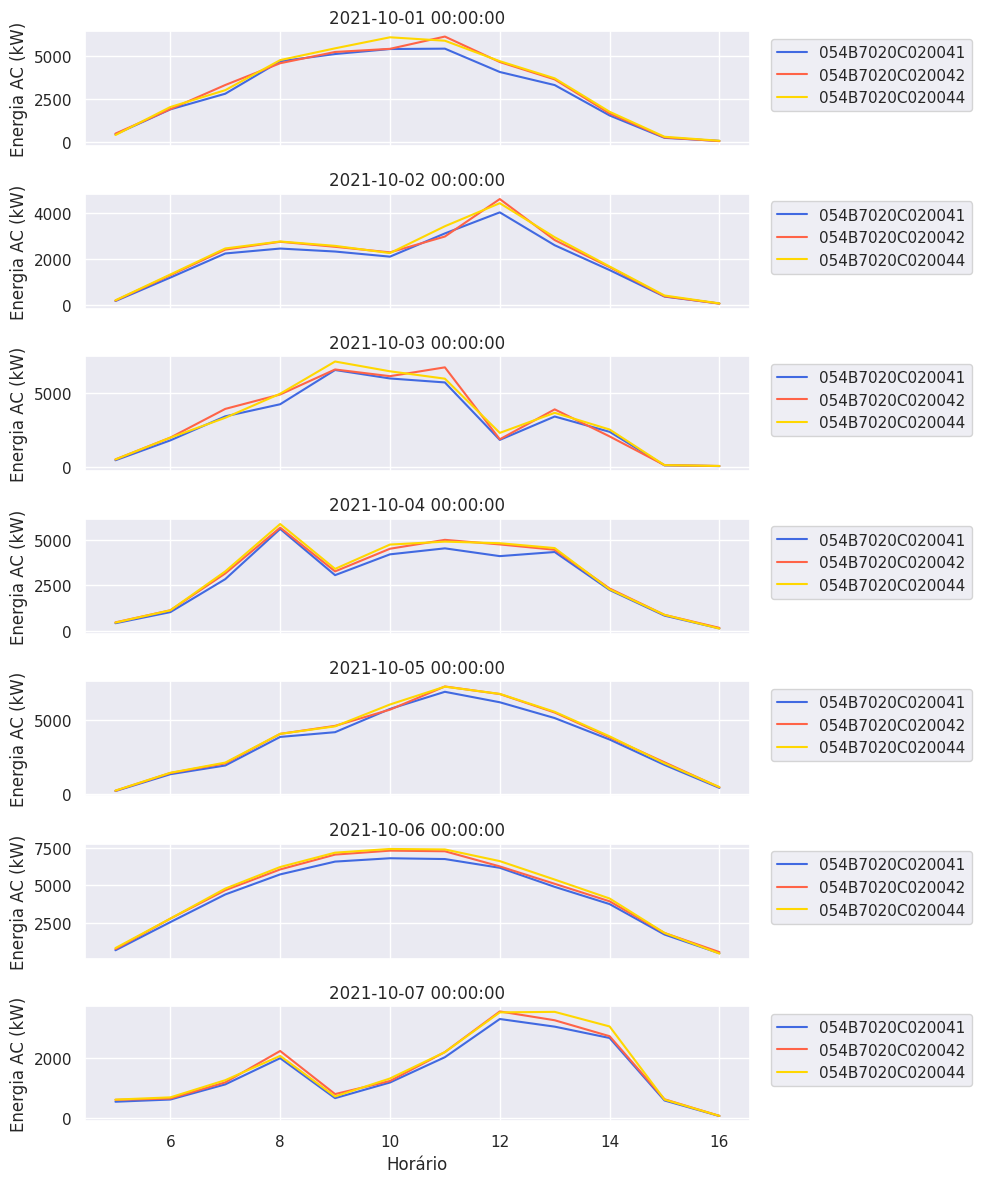

In [55]:
geracao=df4.copy()

geracao['Horário']=geracao['HOUR']
geracao['Data']=geracao['DATE']

cols=geracao.groupby(['Horário','Data'])['ACPOWER[W]'].mean().unstack()

inversores = ['054B7020C020041', '054B7020C020042', '054B7020C020044']
cores = ['royalblue', 'tomato', 'gold']

inversores_1=df4.loc[df4['INVERTER']=='054B7020C020041'].loc[df4['DATE'] < ('2021-10-08')]
inversores_1['Horário']=inversores_1['HOUR']
inversores_1['Data']=inversores_1['DATE']

ax=inversores_1.groupby(['Horário','Data'])['ACPOWER[W]'].mean().unstack().plot(sharex=True,subplots=True,layout=(7,1),figsize=(10,12), color=cores[0])

j=1
for j in range(1,3):
    inversores_2 =df4.loc[df4['INVERTER']==inversores[j]].loc[df4['DATE'] < ('2021-10-08')]
    inversores_2['Horário']=inversores_2['HOUR']
    inversores_2['Data']=inversores_2['DATE']
    inversores_2.groupby(['Horário','Data'])['ACPOWER[W]'].mean().unstack().plot(sharex=True,subplots=True,layout=(7,1),figsize=(10,12), color=cores[j], ax=ax)
    j=j+1

i=0
for linha in range(len(ax)):
    for coluna in range(len(ax[linha])):
        ax[linha,coluna].set_title(cols.columns[i],size=12)
        ax[linha,coluna].set_ylabel('Energia AC (kW)')
        ax[linha,coluna].legend(inversores, bbox_to_anchor = (1.02, 1))
        i=i+1

plt.tight_layout()
plt.show()

### 4.1.9 Outliers

In [56]:
def boxplot_individuais(data, colunas, largura = 10, altura = 8):
    fig = plt.figure()
    fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
    fig.set_figheight(altura)
    fig.set_figwidth(largura)
    
    ajusteColunas = math.ceil(len(colunas) / 2)
    
    for i, coluna in enumerate(colunas):
        ax = fig.add_subplot(ajusteColunas, 2, i + 1)
        sns.boxplot(x = data[coluna])
        
    plt.tight_layout()
    plt.show()

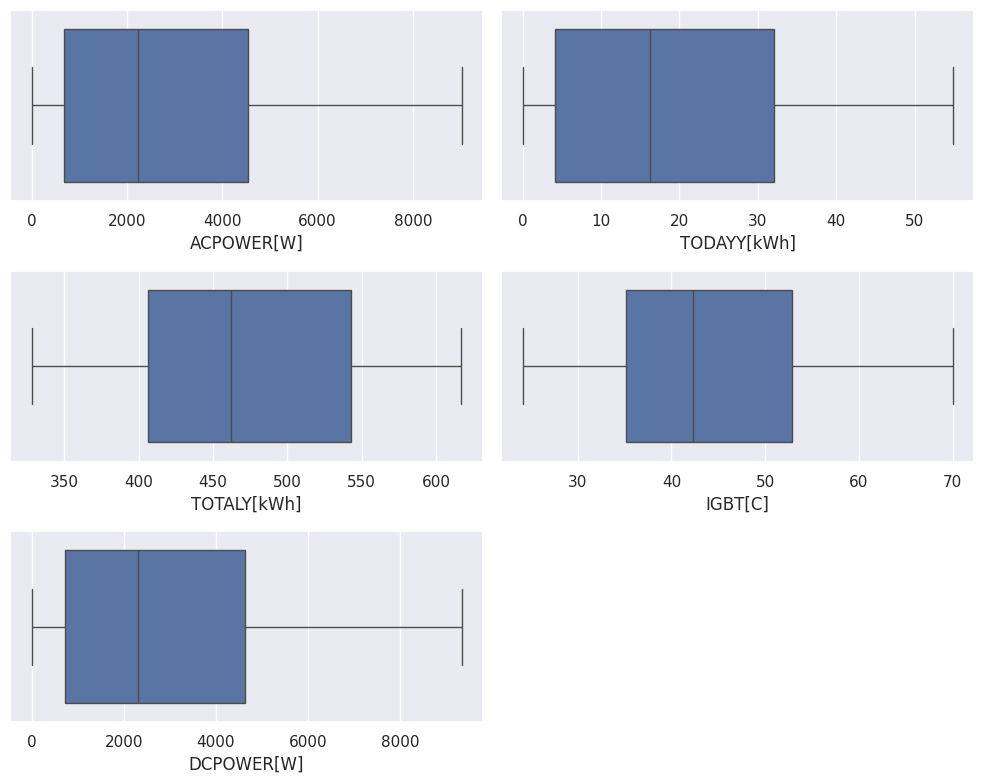

In [57]:
# Retira valores qualitativos da amostra (Data e número de identificação dos inversores)
quantitativos = df4.drop(['INVERTER', 'TIME', 'DATE', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'MIN', 'DAY_WEEK', 'WEEK_YEAR'], axis = 1).columns

boxplot_individuais(df1, quantitativos[0:5])

## 4.2 Análise Multivariada

### 4.2.1 Correlação

In [58]:
df41 = df4.loc[df4['INVERTER'] == '054B7020C020041']
corr_matrix = df41.drop('INVERTER', axis=1).corr()

corr_matrix["ACPOWER[W]"].sort_values(ascending=False)

ACPOWER[W]           1.000000
DCPOWER[W]           0.999896
IGBT[C]              0.899882
ALLSKY_SW[Wh/m^2]    0.804264
UVA[W/m^2]           0.783796
UVB[W/m^2]           0.745651
CLRSKY_SW[Wh/m^2]    0.607007
PS[kPa]              0.376136
T2M[C]               0.280967
WD10M[deg]           0.182796
PREC[mm/hour]        0.123664
TODAYY[kWh]          0.109582
WEEK_YEAR            0.095969
WS10M[m/s]           0.071944
DAY                  0.037307
DATE                 0.037307
TIME                 0.034177
TOTALY[kWh]          0.029638
MIN                  0.028609
HOUR                -0.044518
DAY_WEEK            -0.129191
T2MDEW[C]           -0.212660
QV2M[g/kg]          -0.233734
RH2M[%]             -0.326445
YEAR                      NaN
MONTH                     NaN
Name: ACPOWER[W], dtype: float64

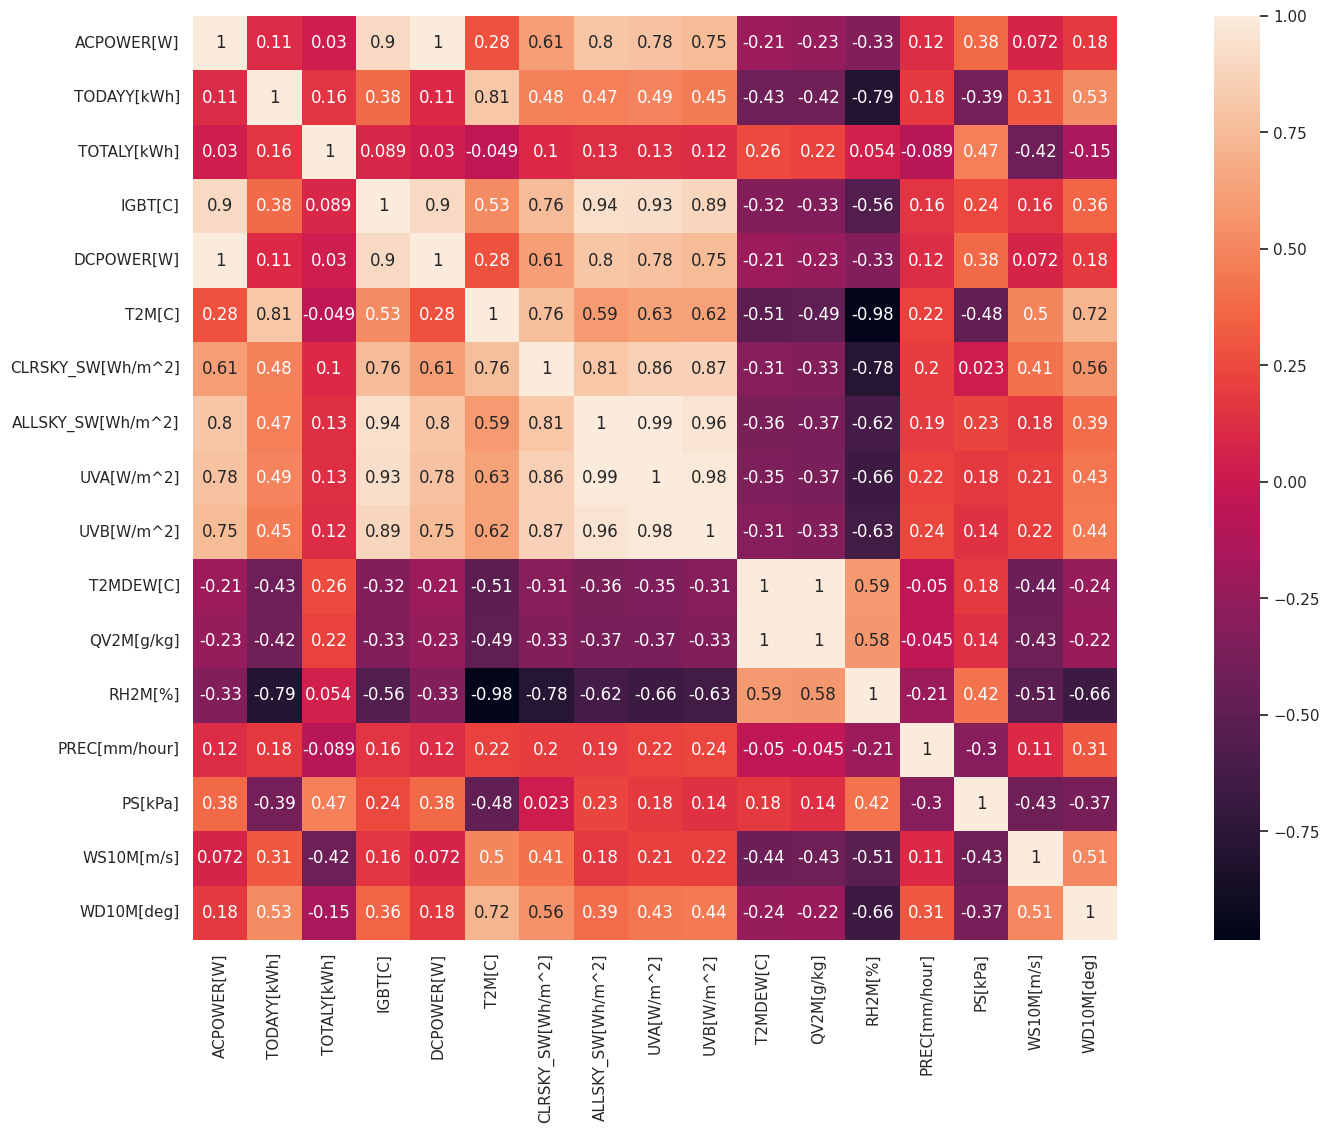

In [59]:
fig = plt.figure()

sns.heatmap(df41.drop(['INVERTER', 'TIME', 'DATE', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'MIN', 'DAY_WEEK', 'WEEK_YEAR'], axis=1).corr(method = 'pearson'), annot = True, square = True)
plt.show()

# 5.0 DATA PREPARATION

In [60]:
# A partir desse ponto apenas o dataset do inversor 054B7020C020041 será utilizado para treinar o algoritmo
df5 = df4.copy()
filtro41 = (df5['INVERTER'] == '054B7020C020041')
filtro42 = (df5['INVERTER'] == '054B7020C020042')
filtro44 = (df5['INVERTER'] == '054B7020C020044')
df5.head()

TIME  ACPOWER[W]  TODAYY[kWh]  TOTALY[kWh]  IGBT[C]  \
9  2021-10-01 05:02:42        20.0          0.0        359.0     27.1   
10 2021-10-01 05:02:52        20.0          0.0        328.0     28.4   
11 2021-10-01 05:03:09        20.0          0.0        359.0     27.9   
12 2021-10-01 05:07:47        20.0          0.0        359.0     27.7   
13 2021-10-01 05:07:56        20.0          0.0        328.0     29.0   

    DCPOWER[W]         INVERTER  T2M[C]  CLRSKY_SW[Wh/m^2]  ALLSKY_SW[Wh/m^2]  \
9         90.0  054B7020C020044   17.54                0.0                0.0   
10        82.0  054B7020C020041   17.54                0.0                0.0   
11       104.0  054B7020C020042   17.54                0.0                0.0   
12        93.0  054B7020C020044   17.54                0.0                0.0   
13        84.0  054B7020C020041   17.54                0.0                0.0   

    ...  WS10M[m/s]  WD10M[deg]       DATE  YEAR  MONTH  WEEK_YEAR  DAY_WEEK  \
9   ...        3.32       33.09 2021-10-01  2021     10         39         5   
10  ...        3.32       33.09 2021-10-01  2021     10         39         5   
11  ...        3.32       33.09 2021-10-01  2021     10         39         5   
12  ...        3.32       33.09 2021-10-01  2021     10         39         5   
13  ...        3.32       33.09 2021-10-01  2021     10         39         5   

    DAY  HOUR MIN  
9     1     5   2  
10    1     5   2  
11    1     5   3  
12    1     5   7  
13    1     5   7  

[5 rows x 27 columns]

## 5.1 Split dataframe into training and test dataset

In [61]:
# training dataset
df_train = df5[filtro41][df5[filtro41]['DATE'] < '2021-10-06']

# test dataset
#df_test = df5[df5['DATE'] >= '2021-10-06']
df_test_41 = df5[filtro41][df5[filtro41]['DATE'] >= '2021-10-06']
df_test_42 = df5[filtro42][df5[filtro42]['DATE'] >= '2021-10-06']

print('Training Min Date: {}'.format(df_train['DATE'].min()))
print('Training Max Date: {}'.format(df_train['DATE'].max()))

print('\nTest Date Min Date: {}'.format(df_test_41['DATE'].min()))
print('Test Max Date: {}'.format(df_test_41['DATE'].max()))

Training Min Date: 2021-10-01 00:00:00
Training Max Date: 2021-10-05 00:00:00

Test Date Min Date: 2021-10-06 00:00:00
Test Max Date: 2021-10-07 00:00:00


## 5.2 Standardization

In [62]:
ss = pp.StandardScaler()

## 5.3 Rescaling

In [63]:
#mms = pp.MinMaxScaler()
mms_y = pp.MinMaxScaler()

In [64]:
def RescalingMMS(df):
    df['ACPOWER[W]']  = mms_y.fit_transform(df[['ACPOWER[W]']].values)
    df['TODAYY[kWh]'] = mms_y.fit_transform(df[['TODAYY[kWh]']].values)
    df['TOTALY[kWh]'] = mms_y.fit_transform(df[['TOTALY[kWh]']].values)
    df['IGBT[C]']     = mms_y.fit_transform(df[['IGBT[C]']].values)
    df['DCPOWER[W]']  = mms_y.fit_transform(df[['DCPOWER[W]']].values)
    df['T2M[C]']      = mms_y.fit_transform(df[['T2M[C]']].values)
    df['CLRSKY_SW[Wh/m^2]'] = mms_y.fit_transform(df[['CLRSKY_SW[Wh/m^2]']].values)
    df['ALLSKY_SW[Wh/m^2]'] = mms_y.fit_transform(df[['ALLSKY_SW[Wh/m^2]']].values)
    df['UVA[W/m^2]'] = mms_y.fit_transform(df[['UVA[W/m^2]']].values)
    df['UVB[W/m^2]'] = mms_y.fit_transform(df[['UVB[W/m^2]']].values)
    df['T2MDEW[C]'] = mms_y.fit_transform(df[['T2MDEW[C]']].values)
    df['QV2M[g/kg]'] = mms_y.fit_transform(df[['QV2M[g/kg]']].values)
    df['RH2M[%]'] = mms_y.fit_transform(df[['RH2M[%]']].values)
    df['PREC[mm/hour]'] = mms_y.fit_transform(df[['PREC[mm/hour]']].values)
    df['PS[kPa]'] = mms_y.fit_transform(df[['PS[kPa]']].values)
    df['WS10M[m/s]'] = mms_y.fit_transform(df[['WS10M[m/s]']].values)

In [65]:
RescalingMMS(df_train)
RescalingMMS(df_test_41)
RescalingMMS(df_test_42)
RescalingMMS(df5)

## 5.4 Nature Transformation

In [66]:
def time_transform(df):
    df['month_sin'] = df['MONTH'].apply(lambda x: np.sin(x * (2 * np.pi/12)))
    df['month_cos'] = df['MONTH'].apply(lambda x: np.cos(x * (2 * np.pi/12)))

    df['week_of_year_sin'] = df['WEEK_YEAR'].apply(lambda x: np.sin(x * (2 * np.pi/52)))
    df['week_of_year_cos'] = df['WEEK_YEAR'].apply(lambda x: np.cos(x * (2 * np.pi/52)))

    df['day_of_week_sin'] = df['DAY_WEEK'].apply(lambda x: np.sin(x * (2 * np.pi/7)))
    df['day_of_week_cos'] = df['DAY_WEEK'].apply(lambda x: np.cos(x * (2 * np.pi/7)))

    df['day_sin'] = df['DAY'].apply(lambda x: np.sin(x * (2 * np.pi/30)))
    df['day_cos'] = df['DAY'].apply(lambda x: np.cos(x * (2 * np.pi/30)))

    df['hour_sin'] = df['HOUR'].apply(lambda x: np.sin(x * (2 * np.pi/24)))
    df['hour_cos'] = df['HOUR'].apply(lambda x: np.cos(x * (2 * np.pi/24)))

    df['minute_sin'] = df['MIN'].apply(lambda x: np.sin(x * (2 * np.pi/60)))
    df['minute_cos'] = df['MIN'].apply(lambda x: np.cos(x * (2 * np.pi/60)))

    cols_drop = ['MONTH', 'WEEK_YEAR', 'DAY_WEEK', 'DAY', 'HOUR', 'MIN', 'DATE']
    df = df.drop(cols_drop, axis = 1, inplace=True)
    return None

### 5.4.1 Training

In [67]:
time_transform(df_train)

### 5.4.2 Test

In [68]:
time_transform(df_test_41)

### 5.4.2 Complete

In [69]:
time_transform(df5)

# 6.0 FEATURE SELECTION

In [70]:
df6 = df5.copy()

## 6.1 Feature Selection df1

### 6.1.1 Target variable

In [71]:
# training dataset
y_train_41 = df_train[filtro41][['ACPOWER[W]']]

# test dataset
y_test_41 = df_test_41[['ACPOWER[W]']]

# dataset completo
y_completo_41 = df6[filtro41][['ACPOWER[W]']]

### 6.1.2 Boruta as Feature Selector

In [72]:
df_train.dtypes

TIME                 datetime64[ns]
ACPOWER[W]                  float64
TODAYY[kWh]                 float64
TOTALY[kWh]                 float64
IGBT[C]                     float64
DCPOWER[W]                  float64
INVERTER                     object
T2M[C]                      float64
CLRSKY_SW[Wh/m^2]           float64
ALLSKY_SW[Wh/m^2]           float64
UVA[W/m^2]                  float64
UVB[W/m^2]                  float64
T2MDEW[C]                   float64
QV2M[g/kg]                  float64
RH2M[%]                     float64
PREC[mm/hour]               float64
PS[kPa]                     float64
WS10M[m/s]                  float64
WD10M[deg]                  float64
YEAR                          int32
month_sin                   float64
month_cos                   float64
week_of_year_sin            float64
week_of_year_cos            float64
day_of_week_sin             float64
day_of_week_cos             float64
day_sin                     float64
day_cos                     

In [73]:
# training and test dataset for Boruta
X_train_n = df_train.drop(['TIME', 'ACPOWER[W]', 'TODAYY[kWh]', 'TOTALY[kWh]', 'IGBT[C]', 'DCPOWER[W]', 'INVERTER'], axis = 1).values
y_train_n = y_train_41.values.ravel() # ravel is to vetorize the values

In [74]:
# define randomforestregressor
rf = RandomForestRegressor(n_jobs = -1)

In [75]:
boruta = BorutaPy(rf, n_estimators = 'auto', verbose = 2, random_state = 42).fit(X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0


Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	6
Tentative: 	3
Rejected: 	16
Iteration: 	9 / 100
Confirmed: 	6
Tentative: 	3
Rejected: 	16
Iteration: 	10 / 100
Confirmed: 	6
Tentative: 	3
Rejected: 	16
Iteration: 	11 / 100
Confirmed: 	6
Tentative: 	3
Rejected: 	16
Iteration: 	12 / 100
Confirmed: 	6
Tentative: 	3
Rejected: 	16
Iteration: 	13 / 100
Confirmed: 	6
Tentative: 	3
Rejected: 	16
Iteration: 	14 / 100
Confirmed: 	6
Tentative: 	3
Rejected: 	16
Iteration: 	15 / 100
Confirmed: 	6
Tentative: 	3
Rejected: 	16
Iteration: 	16 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	16
Iteration: 	17 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	16
Iteration: 	18 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	16
Iteration: 	19 / 100
Confirmed: 	9
Tentative: 	0
Rejected: 	16


BorutaPy finished running.

Iteration: 	20 / 100
Confirmed

### 6.2.1 Best Features from Boruta

In [76]:
cols_selected = boruta.support_.tolist()

# best features
X_train_fs = df_train.drop(['TIME', 'ACPOWER[W]', 'TODAYY[kWh]', 'TOTALY[kWh]', 'IGBT[C]', 'DCPOWER[W]', 'INVERTER'], axis = 1) 

In [77]:
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

In [78]:
cols_selected_boruta

['CLRSKY_SW[Wh/m^2]',
 'ALLSKY_SW[Wh/m^2]',
 'UVA[W/m^2]',
 'UVB[W/m^2]',
 'PS[kPa]',
 'WD10M[deg]',
 'hour_sin',
 'minute_sin',
 'minute_cos']

# 7.0 MACHINE LEARNING MODELING

In [79]:
df7 = df6.copy()

In [80]:
x_train = df_train[cols_selected_boruta]
x_test_41  = df_test_41[cols_selected_boruta]

y_completo_41 = y_completo_41.values

## 7.1 Random Forest Regressor

In [81]:
rf = RandomForestRegressor(n_estimators = 25, n_jobs = -1, random_state = 42).fit(x_train, y_train_41)

In [82]:
# prediction
yhat_rf_41 = pd.DataFrame(rf.predict(x_test_41))

### 7.1.1 Normalized Data

In [83]:
# performance
rf_result_41 = ml_error('Random forest Regressor', y_test_41, yhat_rf_41)
rf_result_41

Model Name       MAE          MAPE      RMSE
0  Random forest Regressor  0.137842  9.707511e+11  0.184232

In [84]:
y_test_41_rf = y_test_41.values
yhat_rf_41 = yhat_rf_41.values

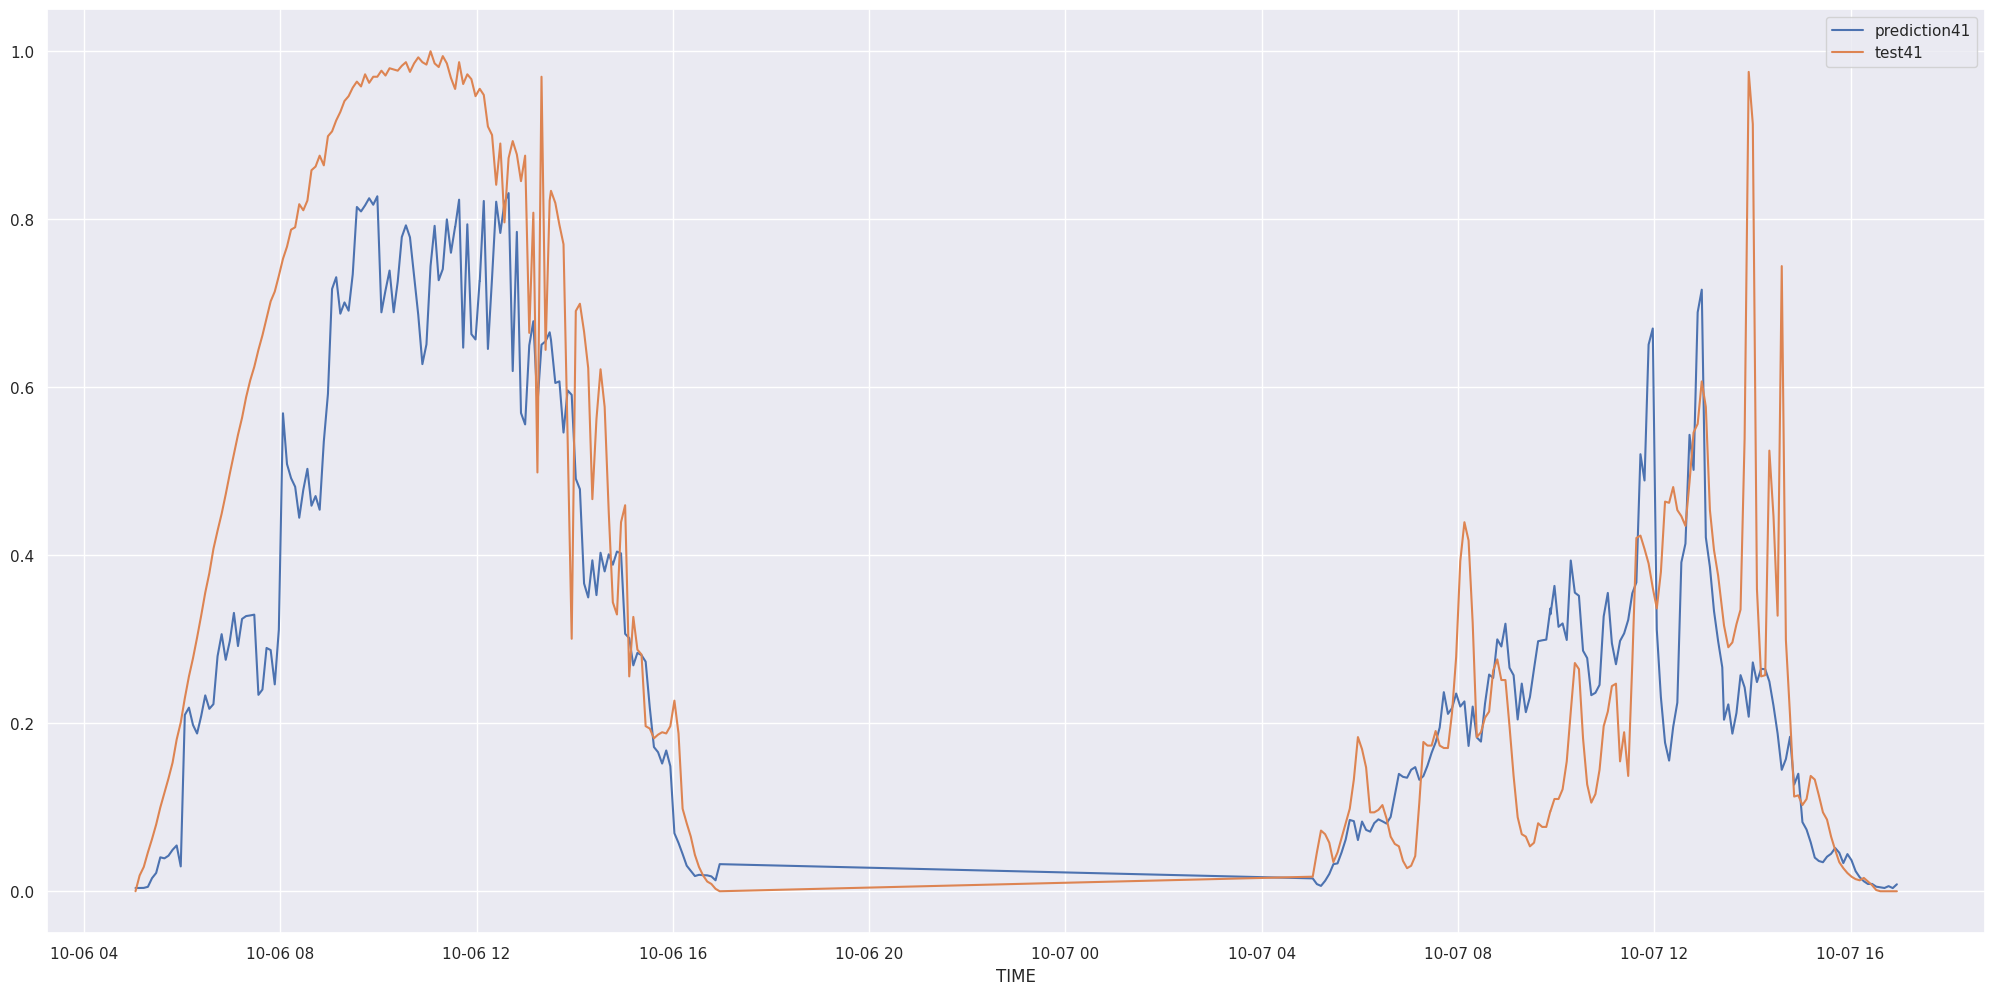

In [85]:
sns.lineplot(x = df_test_41['TIME'], y = yhat_rf_41[:, 0], label = 'prediction41')
sns.lineplot(x = df_test_41['TIME'], y = y_test_41_rf[:,0], label = 'test41');

### 7.1.2 Inverse Transform

In [86]:
# performance
rf_result = ml_error('Random forest Regressor', mms_y.inverse_transform(y_test_41), mms_y.inverse_transform(yhat_rf_41))
rf_result

Model Name       MAE      MAPE      RMSE
0  Random forest Regressor  1.119277  0.289885  1.495967

In [87]:
y_train_41_rf = y_train_41.values

In [88]:
y_test_41_rf = mms_y.inverse_transform(y_test_41)
yhat_rf_41 = mms_y.inverse_transform(yhat_rf_41)
y_completo_41_rf = mms_y.inverse_transform(y_completo_41)
y_train_41_rf = mms_y.inverse_transform(y_train_41_rf)

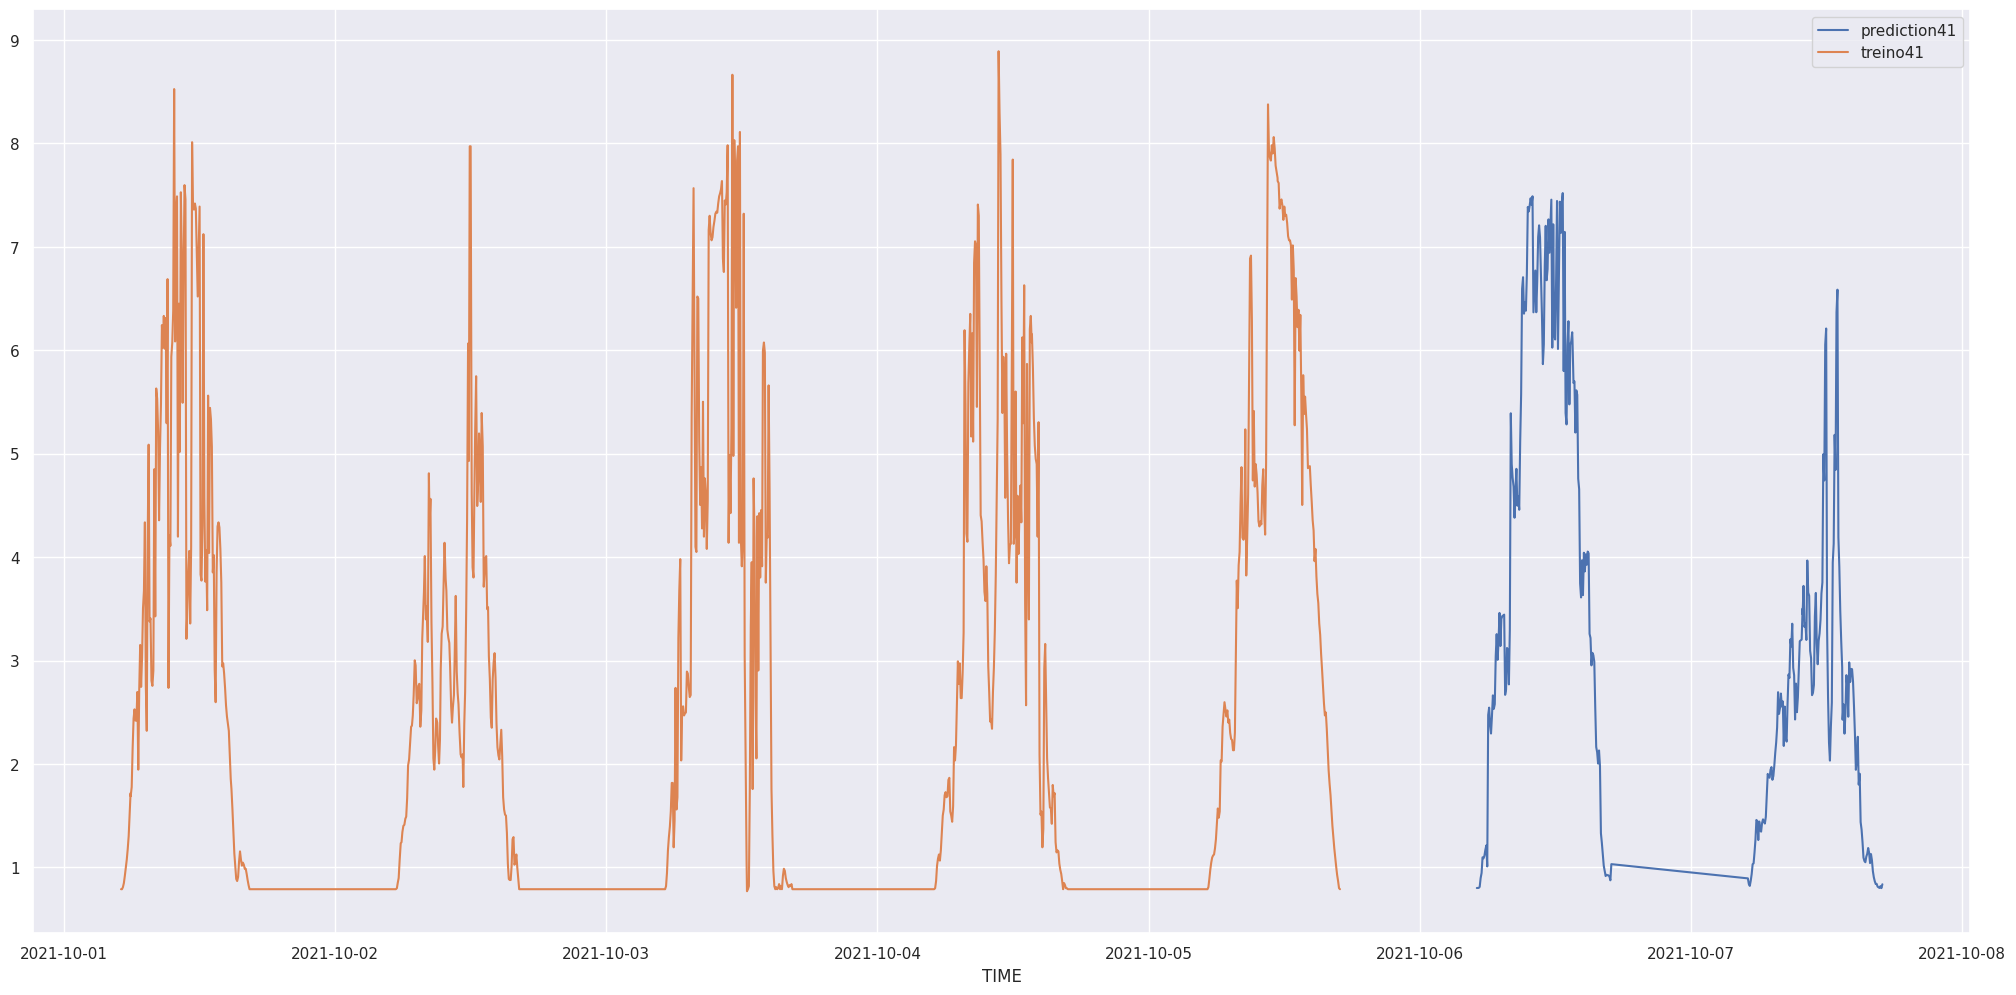

In [89]:
sns.lineplot(x = df_test_41['TIME'], y = yhat_rf_41[:,0], label = 'prediction41')
sns.lineplot(x = df_train['TIME'], y = y_train_41_rf[:,0], label = 'treino41');

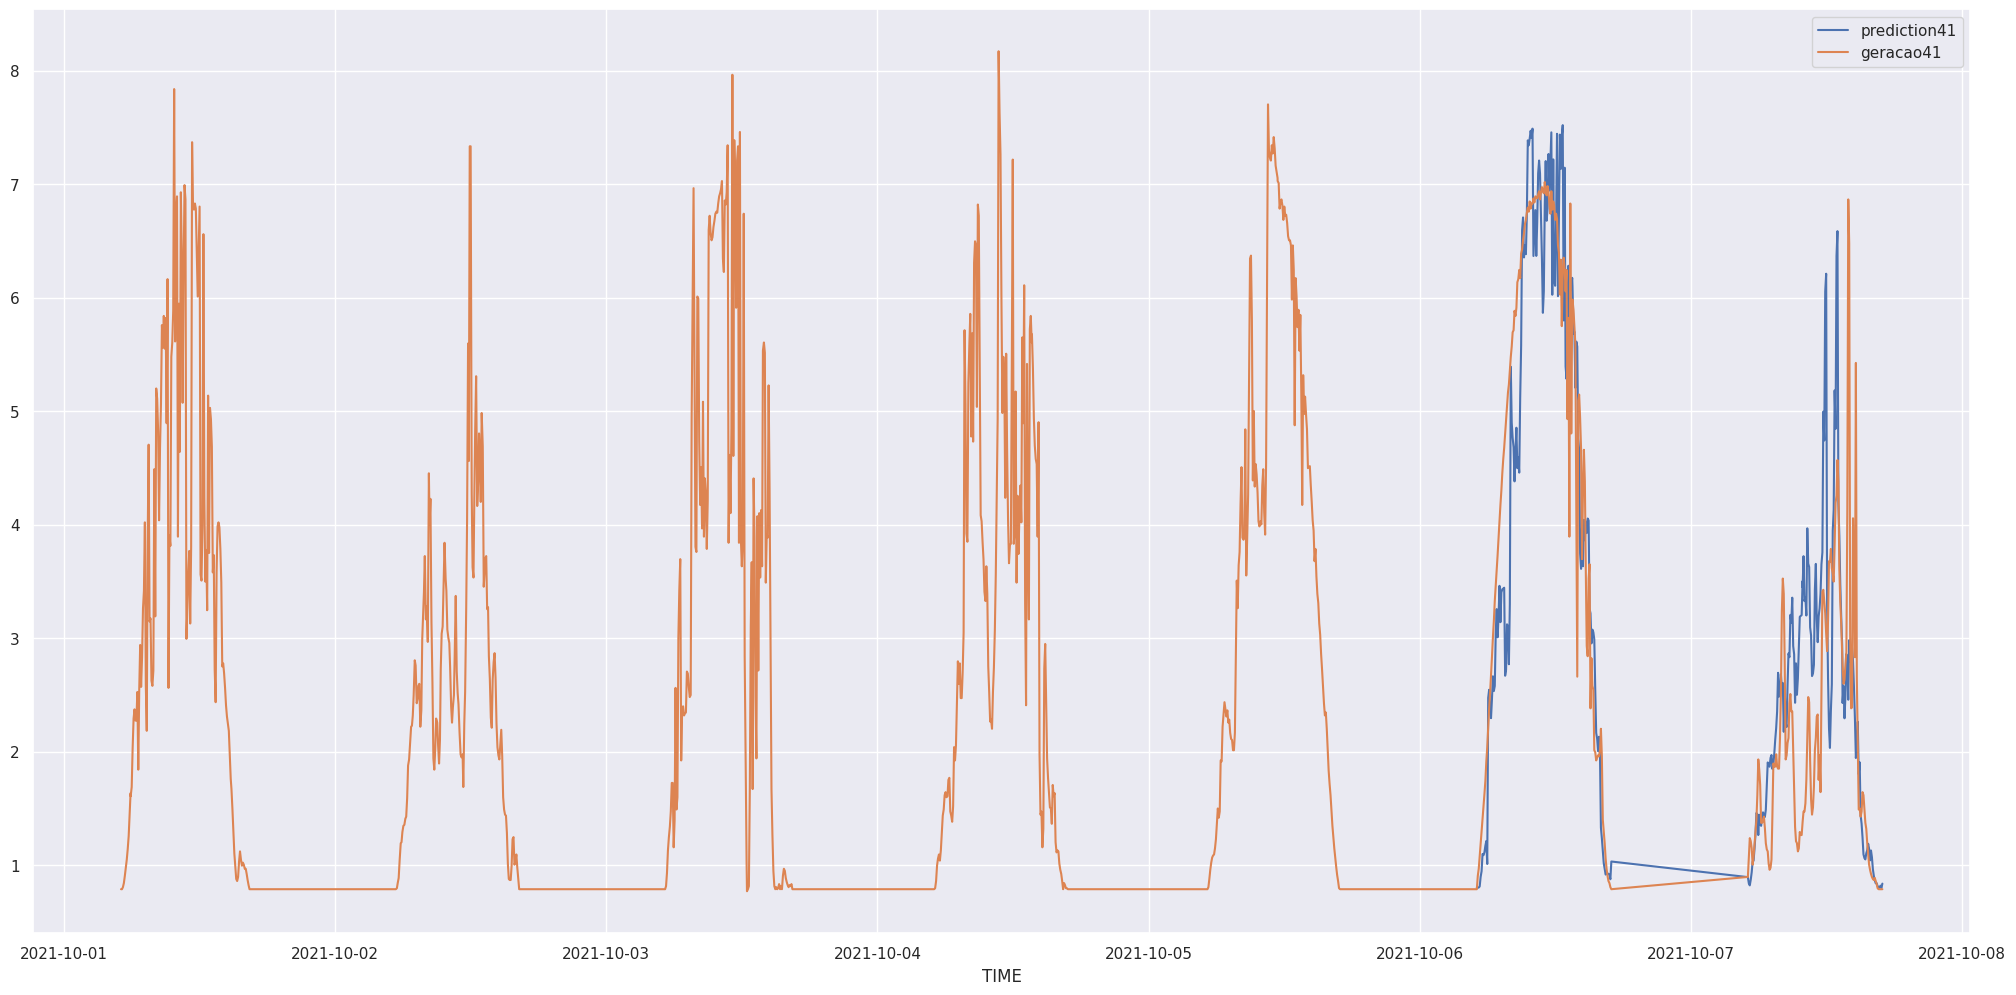

In [90]:
sns.lineplot(x = df_test_41['TIME'], y = yhat_rf_41[:,0], label = 'prediction41')
sns.lineplot(x = df7[filtro41]['TIME'], y = y_completo_41_rf[:,0], label = 'geracao41');

## 7.2 Linear Regression Model

In [91]:
# model
lr = LinearRegression().fit(x_train, y_train_41)

In [92]:
# prediction
yhat_lr_41 = pd.DataFrame(lr.predict(x_test_41))

### 7.2.1 Normalized Data

In [93]:
# performance
lr_result_41 = ml_error('Linear Regression', y_test_41, yhat_lr_41)
lr_result_41

Model Name      MAE          MAPE      RMSE
0  Linear Regression  0.13664  3.509425e+12  0.170082

In [94]:
y_test_41_lr = y_test_41.values
yhat_lr_41 = yhat_lr_41.values

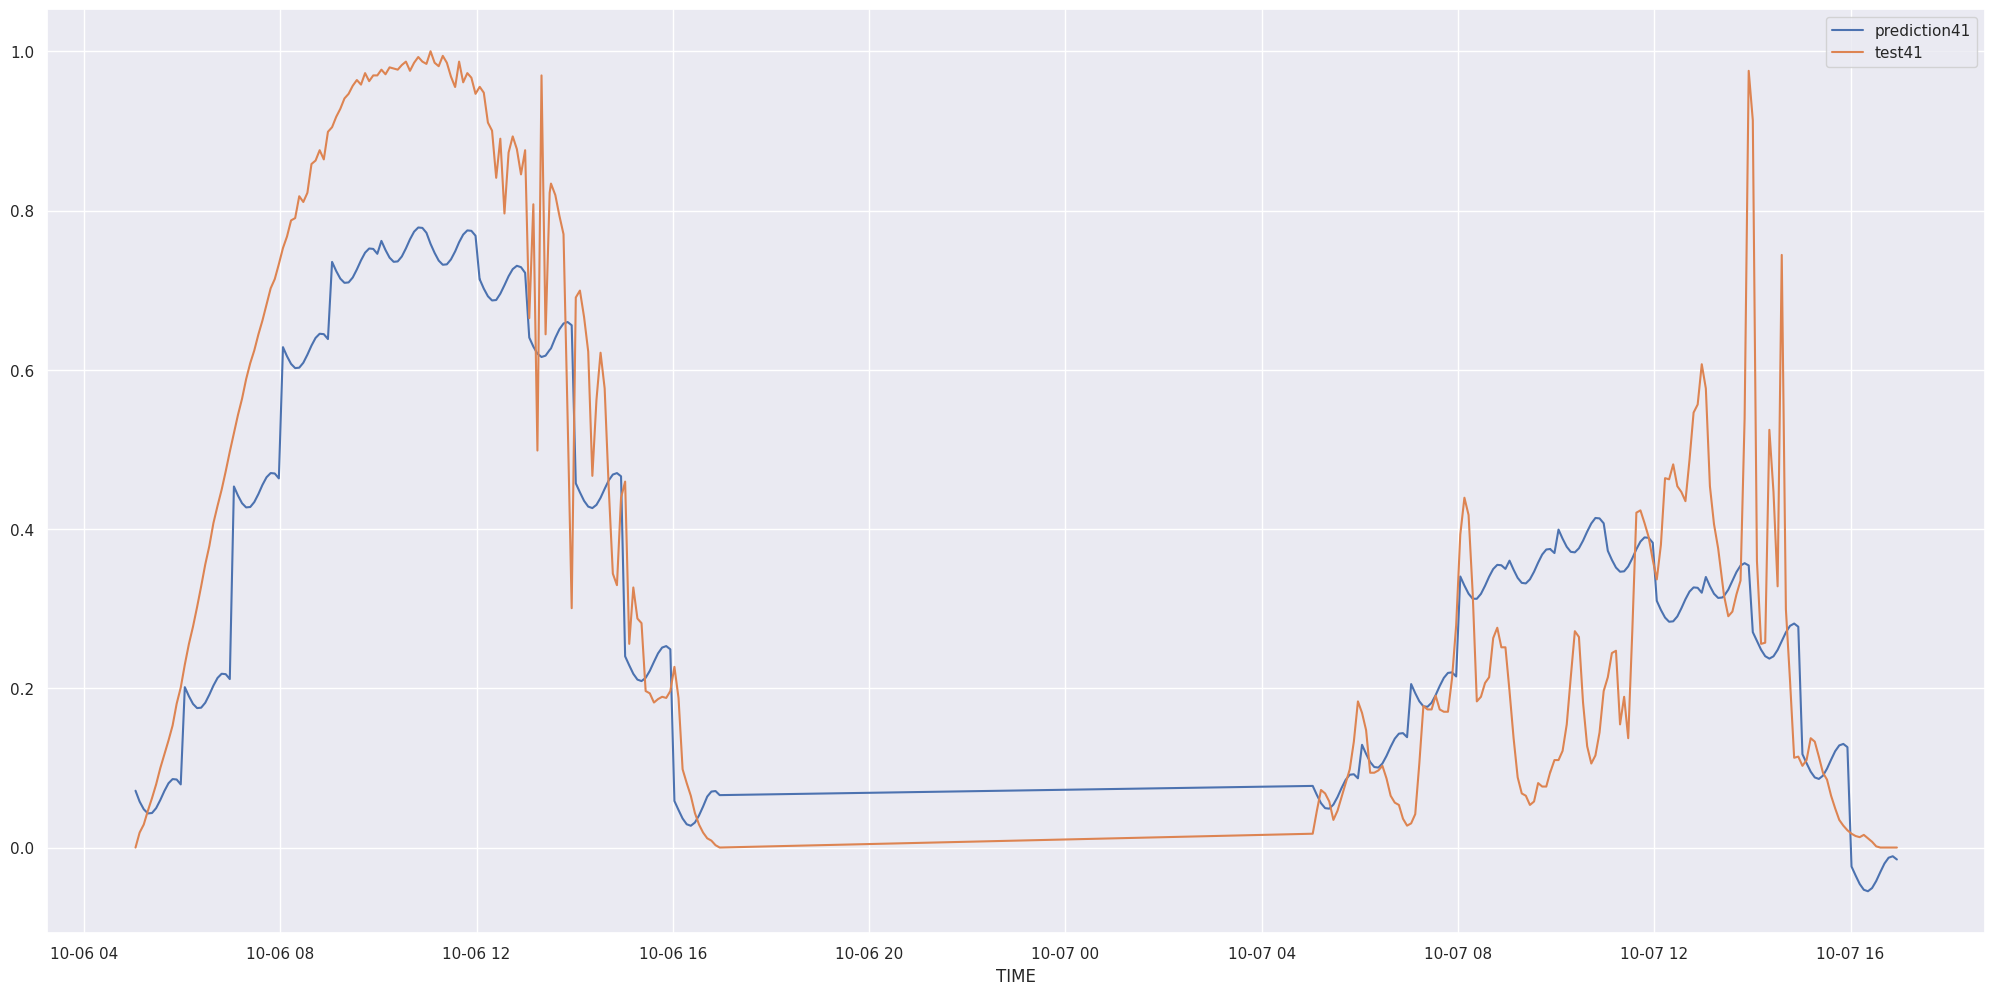

In [95]:
sns.lineplot(x = df_test_41['TIME'], y = yhat_lr_41[:, 0], label = 'prediction41')
sns.lineplot(x = df_test_41['TIME'], y = y_test_41_lr[:,0], label = 'test41');

### 7.2.2 Inverse Transform

In [96]:
# performance
lr_result = ml_error('Linear Regression', mms_y.inverse_transform(y_test_41), mms_y.inverse_transform(yhat_lr_41))
lr_result

Model Name       MAE      MAPE      RMSE
0  Linear Regression  1.109514  0.347183  1.381069

In [97]:
y_train_41_lr = y_train_41.values

In [98]:
y_test_41_lr = mms_y.inverse_transform(y_test_41)
yhat_lr_41 = mms_y.inverse_transform(yhat_lr_41)
y_completo_41_lr= mms_y.inverse_transform(y_completo_41)
y_train_41_lr = mms_y.inverse_transform(y_train_41_lr)

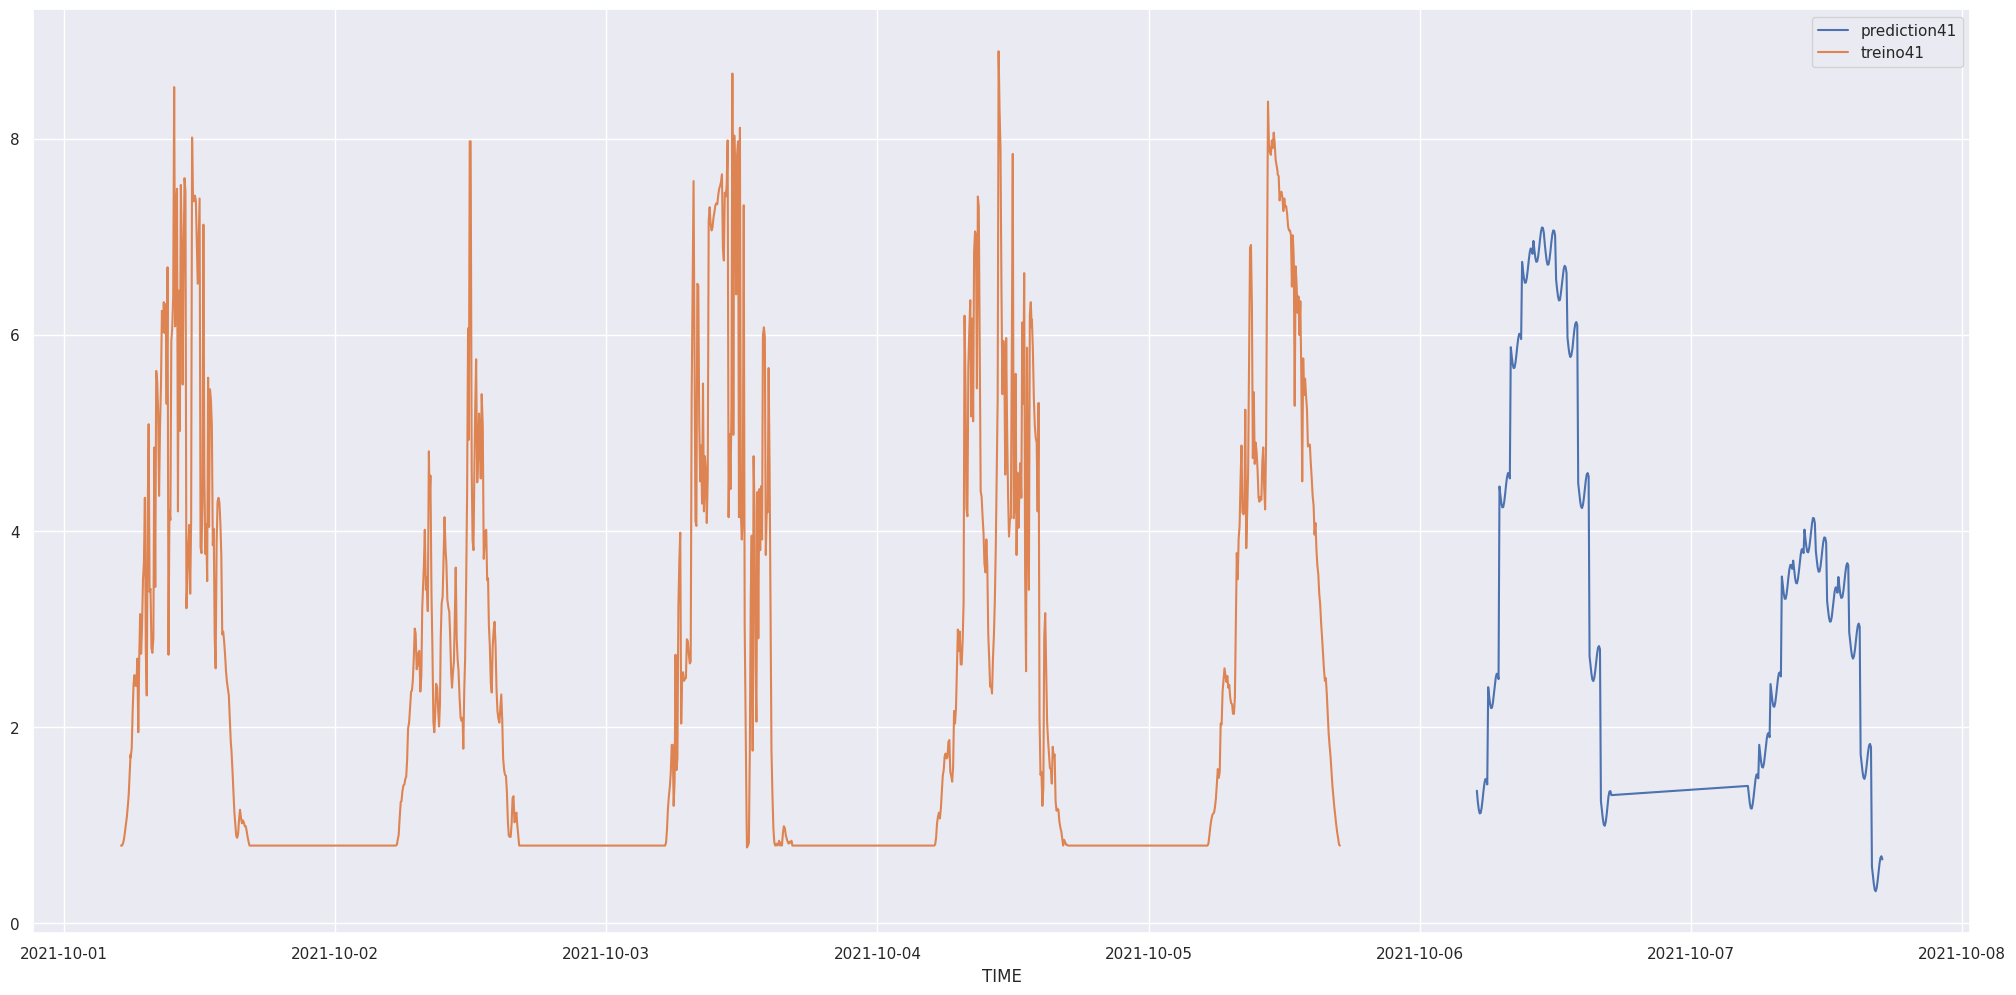

In [99]:
sns.lineplot(x = df_test_41['TIME'], y = yhat_lr_41[:,0], label = 'prediction41')
sns.lineplot(x = df_train['TIME'], y = y_train_41_lr[:,0], label = 'treino41');

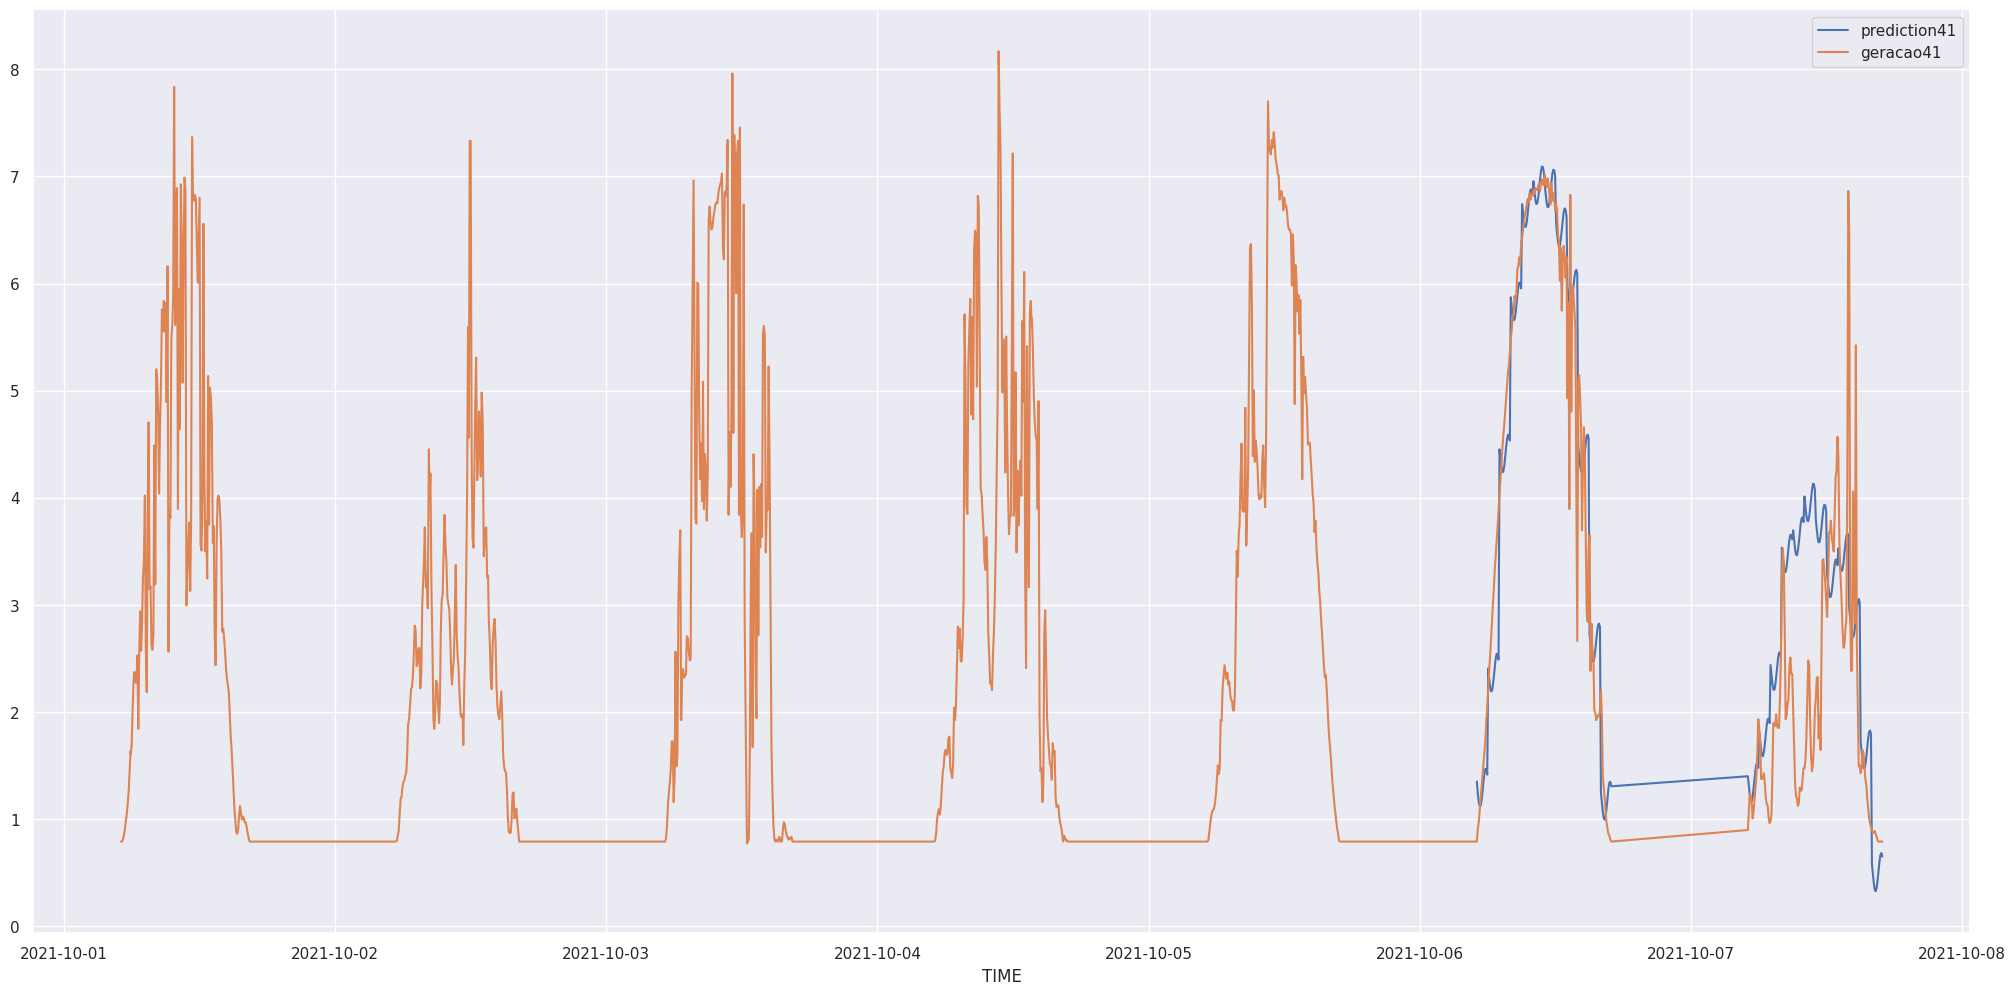

In [100]:
sns.lineplot(x = df_test_41['TIME'], y = yhat_lr_41[:,0], label = 'prediction41')
sns.lineplot(x = df7[filtro41]['TIME'], y = y_completo_41_lr[:,0], label = 'geracao41');

## 7.3 Decision Tree Regressor

In [101]:
# model
dt = DecisionTreeRegressor().fit(x_train, y_train_41)

In [102]:
# prediction
yhat_dt_41 = pd.DataFrame(dt.predict(x_test_41))

### 7.3.1 Normalized Data

In [103]:
# performance
dt_result_41 = ml_error('Decision Tree Regressor', y_test_41, yhat_dt_41)
dt_result_41

Model Name      MAE          MAPE      RMSE
0  Decision Tree Regressor  0.17178  2.635864e+11  0.243482

In [104]:
y_test_41_dt = y_test_41.values
yhat_dt_41 = yhat_dt_41.values

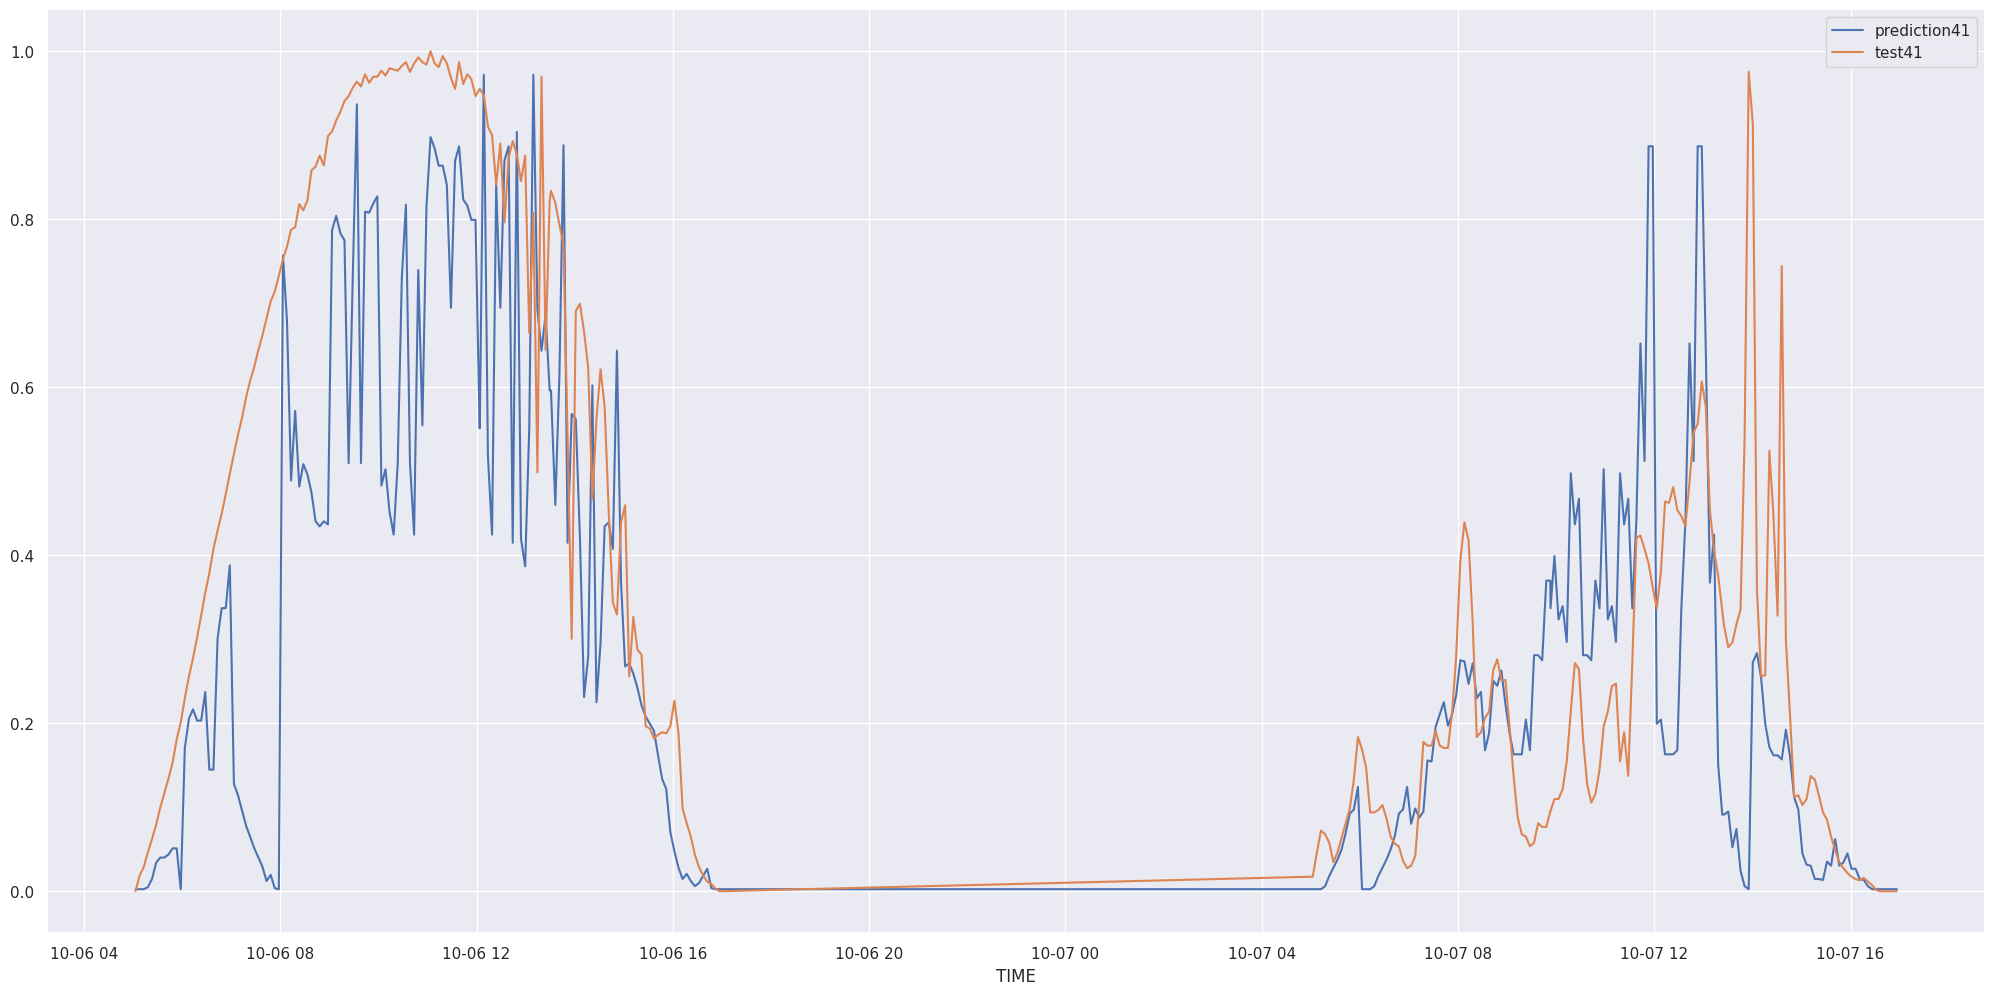

In [105]:
sns.lineplot(x = df_test_41['TIME'], y = yhat_dt_41[:, 0], label = 'prediction41')
sns.lineplot(x = df_test_41['TIME'], y = y_test_41_dt[:,0], label = 'test41');

### 7.3.2 Inverse Transform

In [106]:
# performance
dt_result = ml_error('Decision Tree Regressor', mms_y.inverse_transform(y_test_41), mms_y.inverse_transform(yhat_dt_41))
dt_result

Model Name       MAE     MAPE     RMSE
0  Decision Tree Regressor  1.394853  0.35133  1.97707

In [107]:
y_train_41_dt = y_train_41.values

In [108]:
y_test_41_dt = mms_y.inverse_transform(y_test_41)
yhat_dt_41 = mms_y.inverse_transform(yhat_dt_41)
y_completo_41_dt = mms_y.inverse_transform(y_completo_41)
y_train_41_dt = mms_y.inverse_transform(y_train_41_dt)

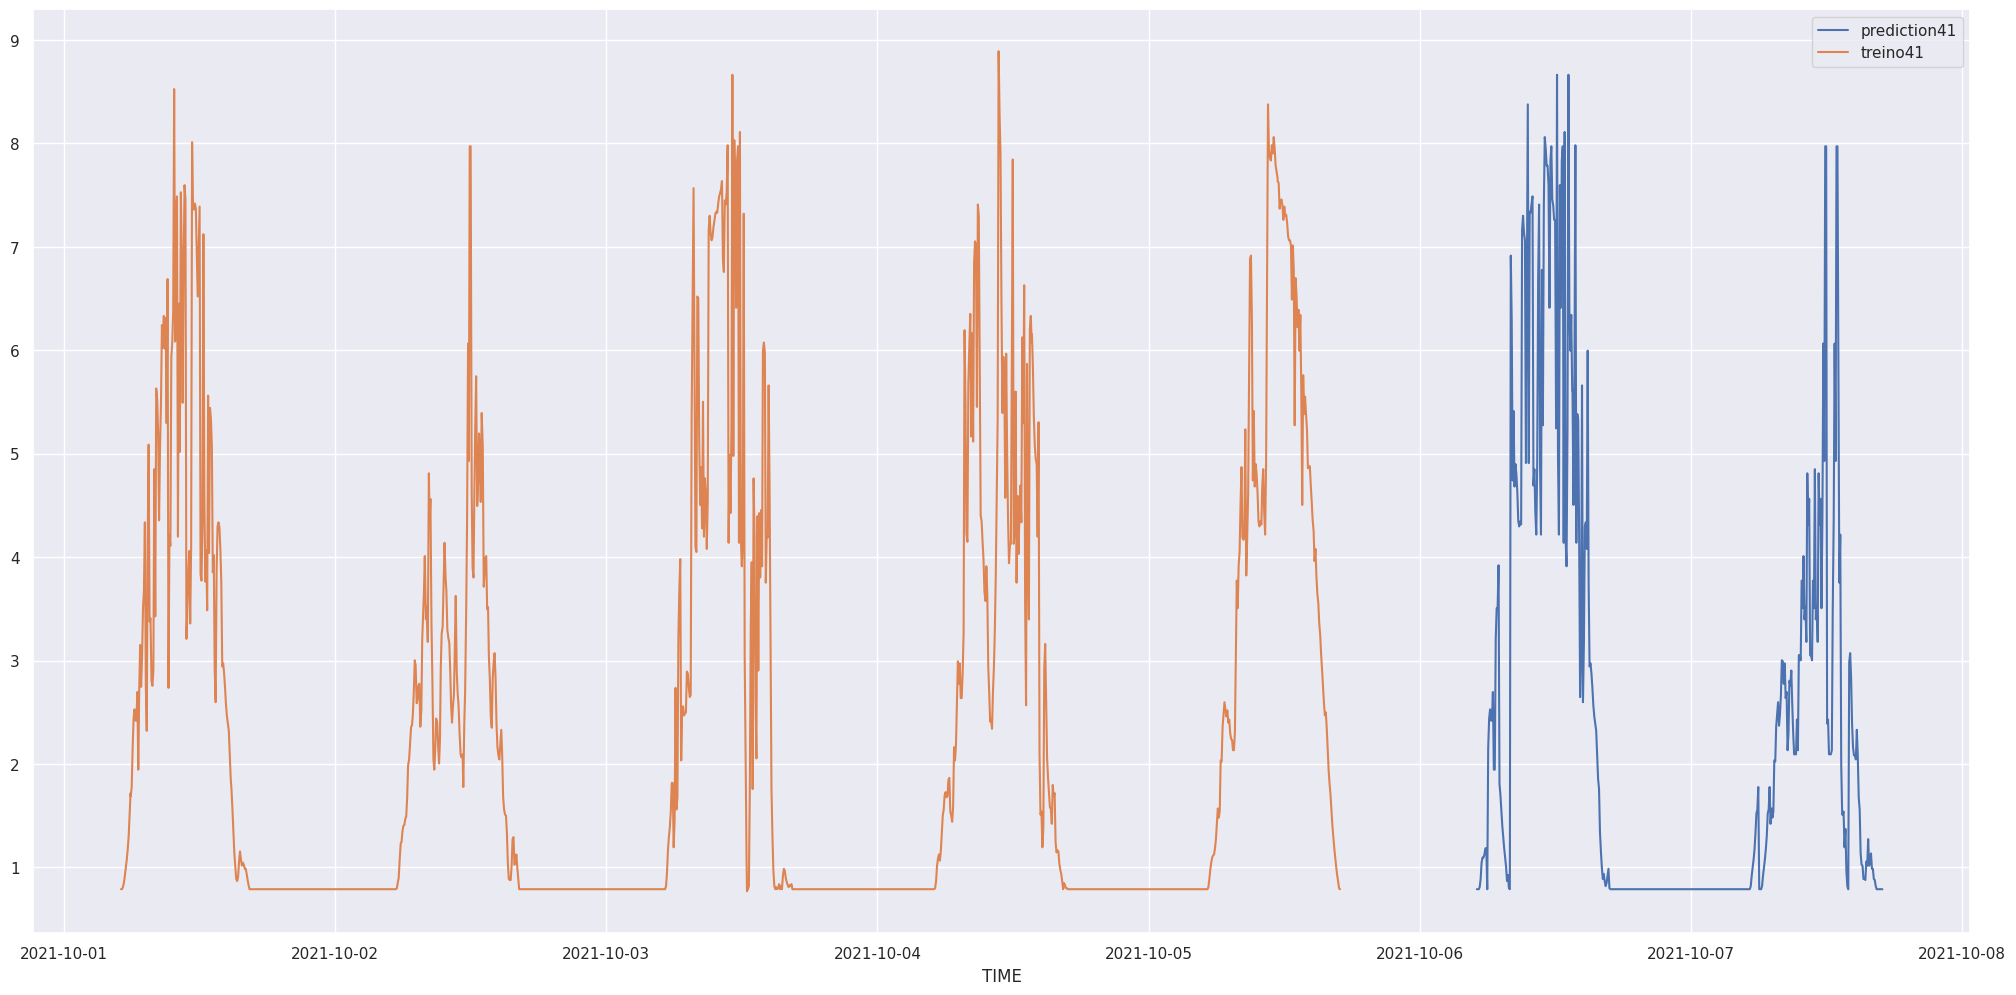

In [109]:
sns.lineplot(x = df_test_41['TIME'], y = yhat_dt_41[:,0], label = 'prediction41')
sns.lineplot(x = df_train['TIME'], y = y_train_41_dt[:,0], label = 'treino41');

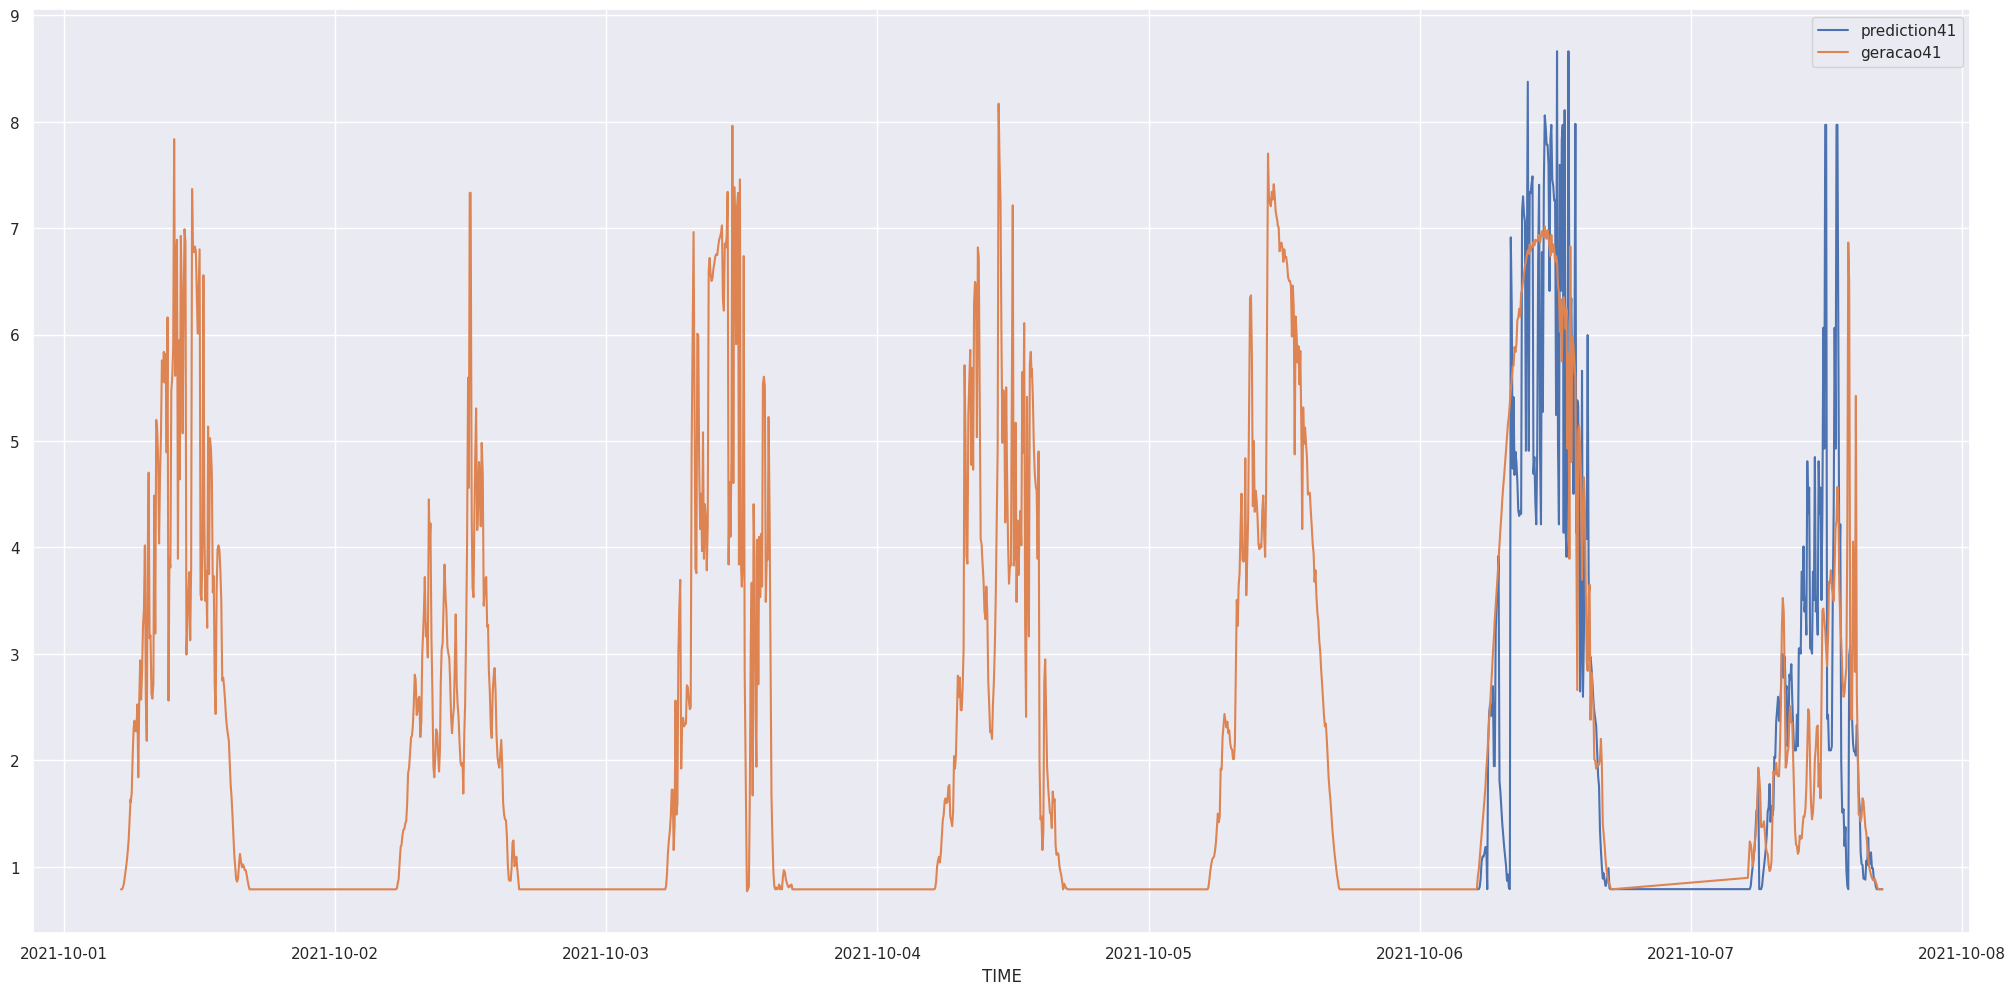

In [110]:
sns.lineplot(x = df_test_41['TIME'], y = yhat_dt_41[:,0], label = 'prediction41')
sns.lineplot(x = df7[filtro41]['TIME'], y = y_completo_41_dt[:,0], label = 'geracao41');

# cross validation